# Car Price Prediction

The purpose of this work is to develop a method for predicting the cost of a car based on known characteristics.
Features that are important to consider when choosing the final model:
  - prediction quality (minimum required value of RMSE metric: 2500)
  - prediction speed
  - learning time
  
First, we will explore the available data, and conduct an exploratory analysis. Then we will clean up and transform the data if necessary. After it will be possible to proceed directly to training and researching ML models. During this work, we will try to consider at least one model based on gradient boosting and one model with a simpler and faster algorithm, for example, a linear regression model.

## Data Preparation

In [ ]:
# Installing additional library for postal code processing and phi-coefficient
!pip install pgeocode
!pip install phik

In [1]:
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pgeocode
import phik
import lightgbm as lgb
from catboost import CatBoostRegressor, Pool
from sklearn.linear_model import Ridge
from sklearn.svm import LinearSVR
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.model_selection import RandomizedSearchCV, train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyRegressor

sns.set(rc={'figure.figsize':(14, 8)}, palette='Set2', font_scale=1.25)
warnings.filterwarnings('ignore')

Set random state

In [2]:
RS = 23

In [3]:
# Data loading
data = pd.read_csv('datasets/autos.csv')


### Exploring the Data

#### Data Description

**Features**  
DateCrawled — date when profile was downloaded from the database  
VehicleType — vehicle body type  
RegistrationYear — vehicle registration year  
Gearbox — gearbox type  
Power — power (hp)  
Model — vehicle model  
Mileage — mileage (km)  
RegistrationMonth — vehicle registration month  
FuelType — fuel type  
Brand — vehicle brand  
NotRepaired — vehicle repaired or not  
DateCreated — date of profile creation  
NumberOfPictures — number of vehicle pictures  
PostalCode — postal code of user profile owner  
LastSeen — date of the last activity of the user  

**Target**  
Price — price (Euro)

In [4]:
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [6]:
data.isna().sum()

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
Repaired             71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

In [7]:
data.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


Let's build distribution histograms for those features where the numerical data type is indicated.

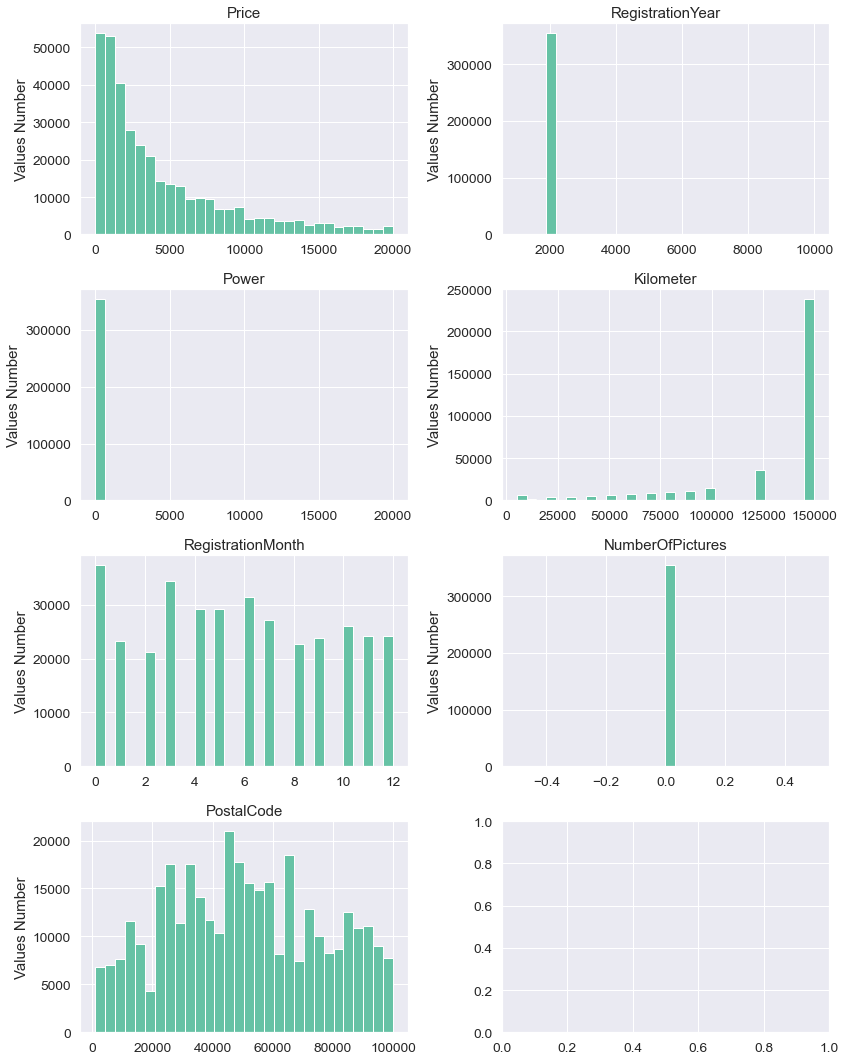

In [8]:
fig, axes = plt.subplots(4, 2, figsize=(12, 15))

data_hist = data[[column for column in data.columns if data[column].dtype == 'int64']]
x_labels = data_hist.columns
i = 0

for biaxis in axes:
    for axis in biaxis:
        try:
            data_hist.hist(column = data_hist.columns[i], bins = 30, ax=axis)
            axis.set_ylabel('Values Number')
            plt.tight_layout()
            i += 1
        except:
            break

###  Check for Duplicates

In [9]:
data.duplicated().sum()

4

There are 4 duplicates in data. We will remove these rows later.

### First observations

1. Missing values. We have five columns with missing values in total:  
    - VehicleType 37490 (Possible to fill in with the most frequent by model and then by brand)  
    - Gearbox 19833 (Fill in with the most frequent by model and then by brand)  
    - Model 19705 (Fill in with the most frequent by brand)  
    - FuelType 32895 (Fill in with the most frequent by model and then by brand)  
    - Repaired 71154 (Fill with zeros)  
2. Data type mismatch  
     - DateCrawled object (preferably converted to datetime)  
     - Repaired object (preferably converted to bool)  
     - DateCreated object (preferably converted to datetime)  
     - LastSeen object (preferably converted to datetime)  
3. There is essentially no information in the NumberOfPictures feature, only zeros everywhere. We can remove this feature, because it is uninformative.  
4. For some reason, there are 13 values in the RegistrationMonth field, instead of 12  
5. Very high power values (> 1000 hp) - study, it is possible to refill by knn  
6. The maximum possible mileage encountered is 150 thousand. km. It is proposed to introduce an additional feature mileage_bigger_150  
7. Anomaly values in the YearOfRegistration column  

### Take a closer look at each feature.

In [10]:
def box_hist_plot(data, column, title, bins=30):
    fig, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
    
    sns.boxplot(data[column], ax=ax_box)
    sns.histplot(data=data, x=column, ax=ax_hist, bins=bins)
    ax_box.set(xlabel='')
    
    fig.suptitle(title)
    plt.show()

#### DataCrawled column

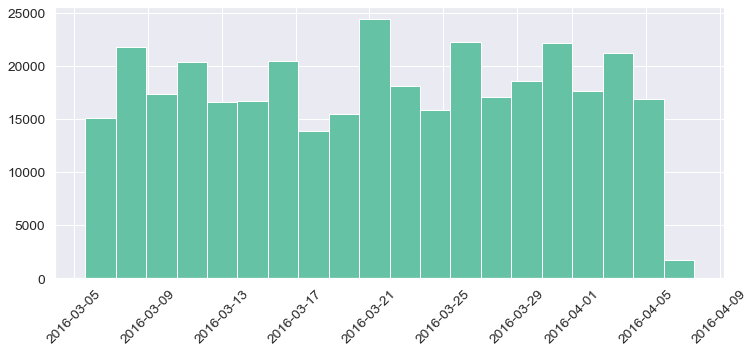

In [11]:
pd.to_datetime(data['DateCrawled']).hist(xrot=45, bins=20, figsize=(12, 5));

It can be seen from the histogram that the data was collected over a period of approximately one month in 2016 from early March to early April.

#### Price column

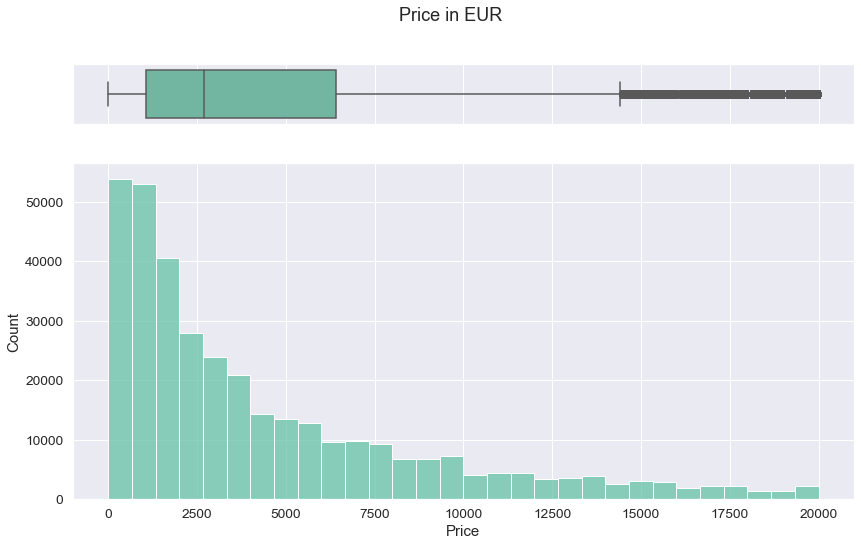

In [12]:
box_hist_plot(data, 'Price', 'Price in EUR', bins=30)

In [13]:
data['Price'].describe()

count    354369.000000
mean       4416.656776
std        4514.158514
min           0.000000
25%        1050.000000
50%        2700.000000
75%        6400.000000
max       20000.000000
Name: Price, dtype: float64

The price distribution is strongly shifted to the left. In addition, there are zero values in data.

In [14]:
data[data['Price'] == 0]

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00,0,19348,2016-03-25 16:47:58
40,2016-03-26 22:06:17,0,NaN,1990,NaN,0,corsa,150000,1,petrol,opel,NaN,2016-03-26 00:00:00,0,56412,2016-03-27 17:43:34
111,2016-03-19 18:40:12,0,NaN,2017,manual,0,golf,5000,12,petrol,volkswagen,NaN,2016-03-19 00:00:00,0,21698,2016-04-01 08:47:05
115,2016-03-20 18:53:27,0,small,1999,NaN,0,NaN,5000,0,petrol,volkswagen,NaN,2016-03-20 00:00:00,0,37520,2016-04-07 02:45:22
152,2016-03-11 18:55:53,0,bus,2004,manual,101,meriva,150000,10,lpg,opel,yes,2016-03-11 00:00:00,0,27432,2016-03-12 23:47:10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354205,2016-03-09 15:56:30,0,NaN,2000,manual,65,corsa,150000,0,NaN,opel,yes,2016-03-09 00:00:00,0,23758,2016-03-30 11:16:08
354238,2016-03-20 14:55:07,0,small,2002,manual,60,fiesta,150000,3,petrol,ford,NaN,2016-03-20 00:00:00,0,33659,2016-04-06 18:45:23
354248,2016-03-24 13:48:05,0,small,1999,manual,53,swift,150000,3,petrol,suzuki,NaN,2016-03-24 00:00:00,0,42329,2016-04-07 05:17:24
354277,2016-03-10 22:55:50,0,small,1999,manual,37,arosa,150000,7,petrol,seat,yes,2016-03-10 00:00:00,0,22559,2016-03-12 23:46:32


There are quite a few such zeros. We can assume that in this case the price is indicated in order to draw attention to the ad. Such data appears to be unreliable. Therefore, the model should not be trained on them. It would be better to remove them.

In [15]:
sorted(data['Price'].unique())[:20]

[0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

There are also near-zero prices.

Here's how we can manage it. We will consider the 0.05 quantile at prices above 0.

In [16]:
data[data['Price'] > 0]['Price'].quantile(q=0.005)

50.0

We will consider all values below this as outliers.

#### Vehicle type column

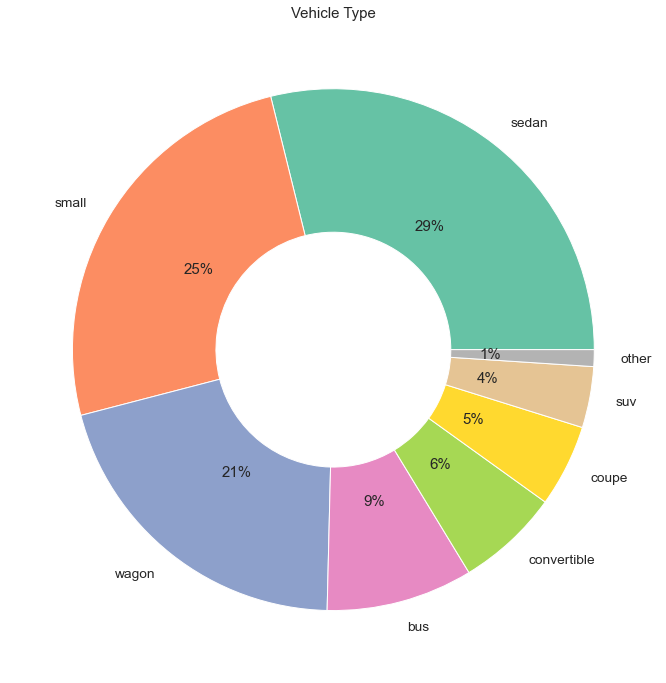

In [17]:
data['VehicleType'].value_counts().plot(kind='pie', 
                         figsize=(12,12), 
                         title='Vehicle Type', 
                         ylabel='', 
                         autopct='%1.0f%%', 
                         wedgeprops=dict(width=0.55, edgecolor='w'));

In [18]:
data['VehicleType'].value_counts()

sedan          91457
small          79831
wagon          65166
bus            28775
convertible    20203
coupe          16163
suv            11996
other           3288
Name: VehicleType, dtype: int64

We have 8 different categories of body types. We can fill in the gaps with the most frequent values for brands and models.

#### RegistrationYear column

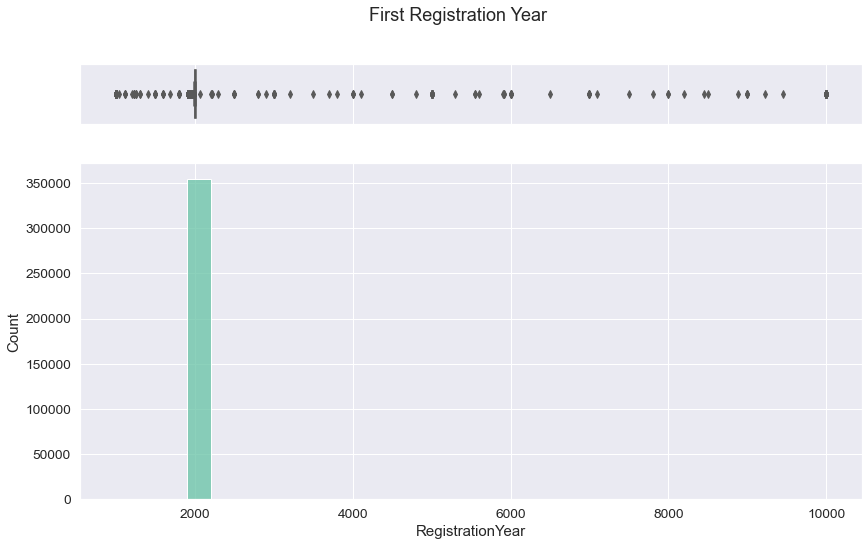

In [19]:
box_hist_plot(data, 'RegistrationYear', 'First Registration Year', bins=30)

As we saw above, there are extremely large values of the year of registration in the data. First, let's find out the last date for uploading data about ads.

In [20]:
max_year_observed = (pd.to_datetime(data['DateCrawled'])).max().year

In [21]:
max_year_observed

2016

\- That is maximum year in our ads. All values above 2016 should be considered as invalid.

In [22]:
data[data['RegistrationYear'] > 2016]['RegistrationYear'].count()

14530

We can see the year of registration later than 2016: 2017, 2018 and more. At the same time, the maximum year for downloading data from the database is 2016. There are quite extreme values, for example 9999. This means that deliberately incorrect data were entered. It would be wrong to train a model on them. Therefore, such data should be deleted.

There are also records with a registration year before 1885 (the year the first production car was released). They should be treated similarly. Let's drop the 0.001 quantile of the column.

In [23]:
data['RegistrationYear'].quantile(q=0.001)

1957.0

All values earlier than this should also be removed, since such old cars are quite rare and their value is often determined by rarity, preservation and collection value (we have no data to determine these parameters). And our task is to determine the value for the needs of ordinary private sellers.

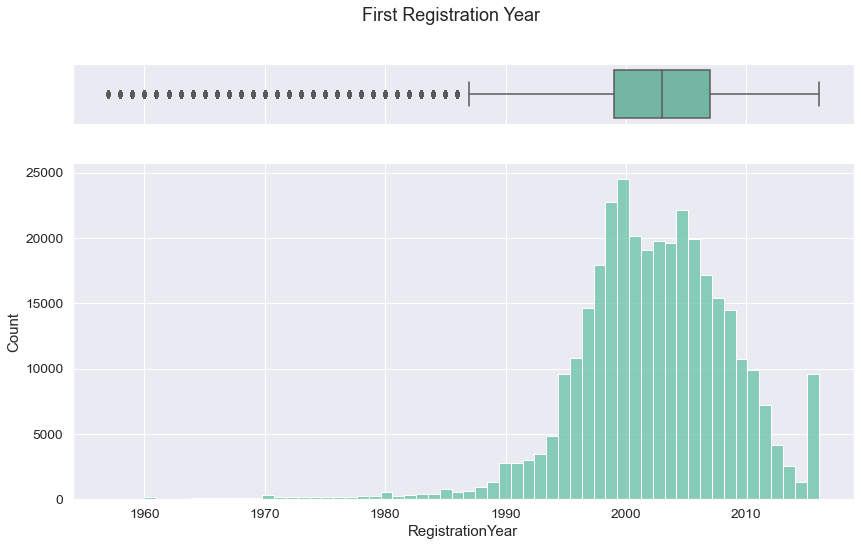

In [24]:
box_hist_plot(data[(data['RegistrationYear'] >= 1957) & 
                   (data['RegistrationYear'] <= 2016)], 
              'RegistrationYear', 
              'First Registration Year', 
              bins=60)

The distribution looks more realistic. There are a lot of entries in 2016. This is suspicious, especially since, as we saw above, all data was uploaded only in March 2016, that is, only for the first quarter.

In [25]:
len(data[(data['RegistrationYear'] == 2014)])

2537

In [26]:
len(data[(data['RegistrationYear'] == 2015)])

1302

Data on cars in 2015 is two times less than in 2014. For cars in 2016, we have almost 10,000 records. If linearly extrapolated, then there should be eight times less such data than for 2015, that is, about 200 records. Against the background of the size of the entire dataset with a size of more than 350 thousand rows, this is negligible, so it would be better to simply delete all data with 2016 cars.

Let's explore also the average mileage of cars produced in 2014-2016.

In [27]:
data[(data['RegistrationYear'] == 2014)]['Kilometer'].mean()

31694.915254237287

In [28]:
data[(data['RegistrationYear'] == 2015)]['Kilometer'].mean()

19101.382488479263

In [29]:
data[(data['RegistrationYear'] == 2016)]['Kilometer'].mean()

133780.08125846443

Cars produced in 2015 number of cars with mileage 150,000:

In [30]:
len(data[(data['RegistrationYear'] == 2015) & (data['Kilometer'] == 150000)])

32

And among the cars of 2016 year number of such cars:

In [31]:
len(data[(data['RegistrationYear'] == 2016) & (data['Kilometer'] == 150000)])

7414

Somehow much more. This distribution is very different from the real one. Apparently, either the year of manufacture or mileage was incorrectly indicated here. Another confirmation of the inaccuracy of the data.

#### Gearbox column

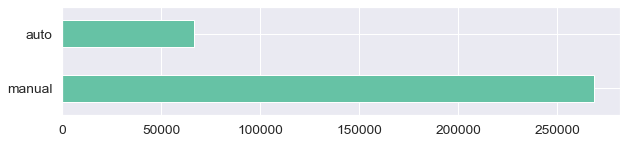

In [32]:
data['Gearbox'].value_counts().plot(kind='barh', figsize=(10, 2));

In [33]:
data['Gearbox'].value_counts()

manual    268251
auto       66285
Name: Gearbox, dtype: int64

Here we have two categories. We can convert it into a sign of the boolean type IsManual. We can fill in the missing values with the most frequent ones by brands and models

#### Power column

As we saw above, there are clear outliers in the power column. Consider data where power values are less than 1000 hp.

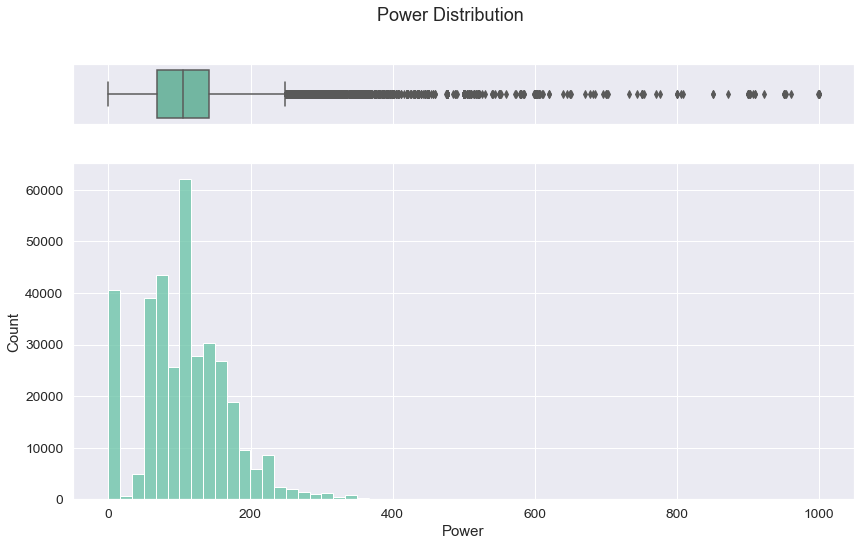

In [34]:
box_hist_plot(data[data['Power'] < 1000], 
              'Power', 
              'Power Distribution', 
              bins=60)

Still a lot of outliers. Let's explore the regular values in more detail.

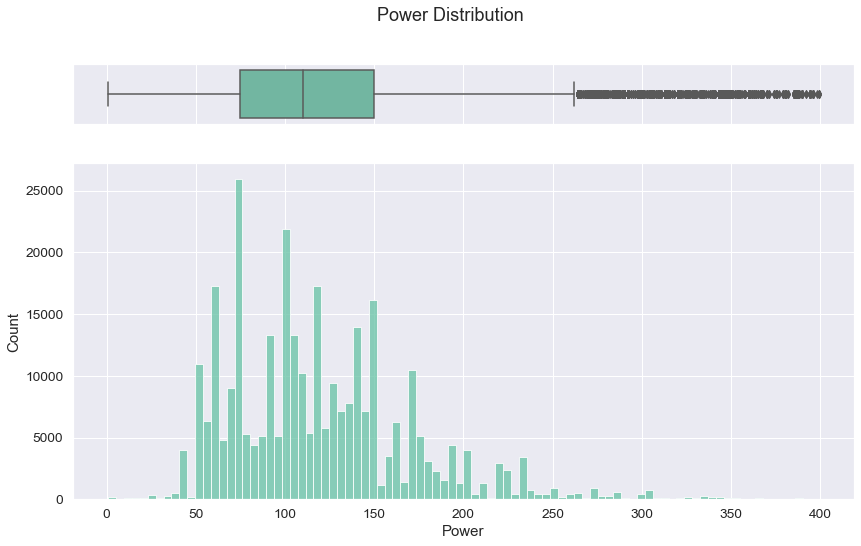

In [35]:
box_hist_plot(data[(data['Power'] < 400) & 
              (data['Power'] > 0)], 
              'Power', 
              'Power Distribution',
              bins=90)

Here we can observe also a lot of data with zero power value.

In [36]:
data[data['Power'] == 0]['Power'].count()

40225

There are a lot of zero power values. More than 10% of all data. The most logical explanation for the zeros in the data is the lack of this information, since a car cannot have zero power. We can fill in zero values and other abnormally low power values with averages for the model or brand.

Let's explore 0.1% of the data with the maximum power value

In [37]:
data['Power'].quantile(q=0.999)

700.0

In [38]:
data[data['Power'] > data['Power'].quantile(q=0.999)]

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
1816,2016-03-22 20:52:00,3200,small,2004,manual,1398,corolla,5000,6,petrol,toyota,no,2016-03-22 00:00:00,0,22043,2016-03-22 21:43:26
2102,2016-03-21 11:55:22,0,sedan,1999,NaN,1799,vectra,150000,1,petrol,opel,yes,2016-03-21 00:00:00,0,1723,2016-04-04 04:49:06
3746,2016-03-21 14:48:31,0,NaN,2017,manual,750,NaN,150000,8,petrol,smart,no,2016-03-21 00:00:00,0,49356,2016-03-24 03:44:59
4060,2016-04-03 20:31:00,3100,sedan,2005,manual,953,colt,150000,4,gasoline,mitsubishi,no,2016-04-03 00:00:00,0,60326,2016-04-07 14:56:46
5328,2016-03-29 19:44:48,500,wagon,1999,manual,1001,astra,150000,7,petrol,opel,NaN,2016-03-29 00:00:00,0,33154,2016-04-06 05:44:36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
348883,2016-03-13 11:51:57,7500,sedan,2011,manual,1548,scenic,90000,4,petrol,renault,NaN,2016-03-13 00:00:00,0,24568,2016-04-06 15:17:39
348968,2016-04-04 18:53:25,250,small,1999,manual,1241,ypsilon,150000,5,petrol,lancia,yes,2016-04-04 00:00:00,0,28259,2016-04-04 18:53:25
351947,2016-03-07 21:36:19,1500,bus,2001,manual,1001,zafira,5000,7,gasoline,opel,no,2016-03-07 00:00:00,0,66117,2016-03-09 12:47:08
353493,2016-04-02 20:54:21,12500,NaN,2017,manual,2000,other,60000,0,gasoline,chrysler,no,2016-04-02 00:00:00,0,44145,2016-04-06 21:44:39


There is data with a clearly incorrectly indicated power. It would be better to remove them. There are not many such data.

#### Model column

Let's explore unique model names.

In [39]:
data['Model'].sort_values().unique()

array(['100', '145', '147', '156', '159', '1_reihe', '1er', '200',
       '2_reihe', '300c', '3_reihe', '3er', '4_reihe', '500', '5_reihe',
       '5er', '601', '6_reihe', '6er', '7er', '80', '850', '90', '900',
       '9000', '911', 'a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'a8',
       'a_klasse', 'accord', 'agila', 'alhambra', 'almera', 'altea',
       'amarok', 'antara', 'arosa', 'astra', 'auris', 'avensis', 'aveo',
       'aygo', 'b_klasse', 'b_max', 'beetle', 'berlingo', 'bora',
       'boxster', 'bravo', 'c1', 'c2', 'c3', 'c4', 'c5', 'c_klasse',
       'c_max', 'c_reihe', 'caddy', 'calibra', 'captiva', 'carisma',
       'carnival', 'cayenne', 'cc', 'ceed', 'charade', 'cherokee',
       'citigo', 'civic', 'cl', 'clio', 'clk', 'clubman', 'colt', 'combo',
       'cooper', 'cordoba', 'corolla', 'corsa', 'cr_reihe', 'croma',
       'crossfire', 'cuore', 'cx_reihe', 'defender', 'delta', 'discovery',
       'doblo', 'ducato', 'duster', 'e_klasse', 'elefantino', 'eos',
       'escort', 'espac

There are no implicit duplicates. We can fill in the gaps with the most frequent values by brand and year of registration.

####  Kilometer column

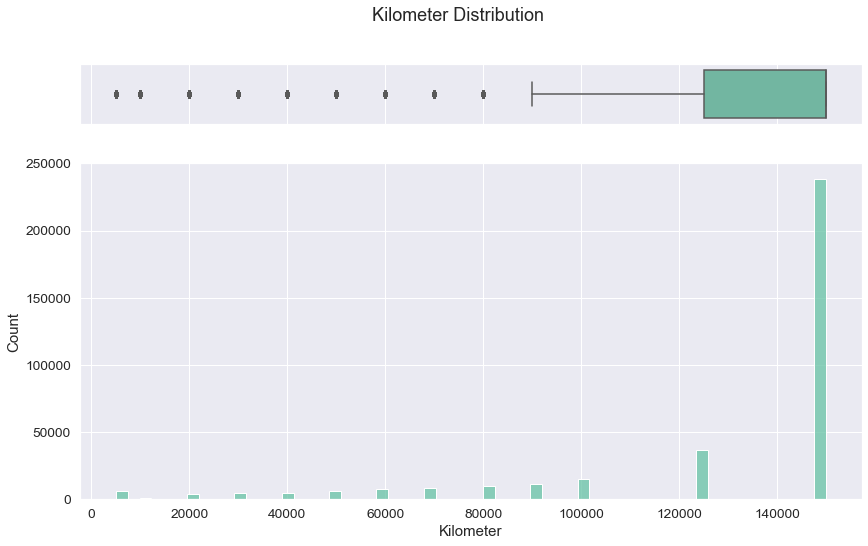

In [40]:
box_hist_plot(data,
              'Kilometer',
              'Kilometer Distribution',
              bins=60)

On the plot we can observe that most of the mileage values are concentrated in the range from 120 to 150 thousand. In addition, the mileage data is discrete. This is probably a feature of the website.

#### RegMonth column

In [41]:
data['RegistrationMonth'].value_counts()

0     37352
3     34373
6     31508
4     29270
5     29153
7     27213
10    26099
12    24289
11    24186
9     23813
1     23219
8     22627
2     21267
Name: RegistrationMonth, dtype: int64

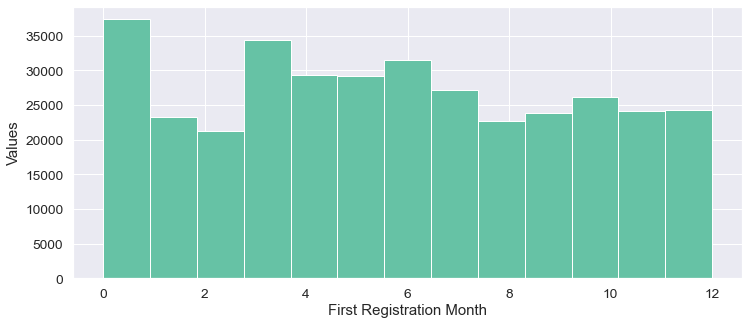

In [42]:
data['RegistrationMonth'].hist(bins=13, 
                               figsize=(12, 5)).set(xlabel='First Registration Month', 
                                                    ylabel='Values');

For some reason, we have 13 month values instead of 12. If we discard the zero value, we see that the distribution is almost uniform. For training models, most likely this feature will not be of great importance. We can remove it.

####  FuelType column

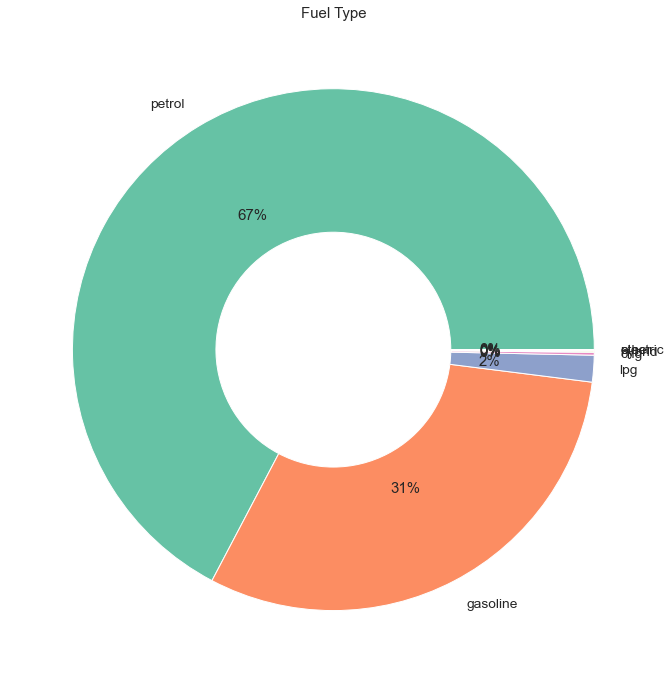

In [43]:
data['FuelType'].value_counts().plot(kind='pie', 
                         figsize=(12,12), 
                         title='Fuel Type', 
                         ylabel='', 
                         autopct='%1.0f%%', 
                         wedgeprops=dict(width=0.55, edgecolor='w'));

In [44]:
data['FuelType'].value_counts()

petrol      216352
gasoline     98720
lpg           5310
cng            565
hybrid         233
other          204
electric        90
Name: FuelType, dtype: int64

For some reason there are petrol and gasoline in a different categories (wich should be the same) and at the same time there is no diesel at all. Probably something from this is diesel. However, this is not essential for training the model. We can leave it as it is. We have 7 categorical features here.

####  Brand column

In [45]:
data['Brand'].unique()

array(['volkswagen', 'audi', 'jeep', 'skoda', 'bmw', 'peugeot', 'ford',
       'mazda', 'nissan', 'renault', 'mercedes_benz', 'opel', 'seat',
       'citroen', 'honda', 'fiat', 'mini', 'smart', 'hyundai',
       'sonstige_autos', 'alfa_romeo', 'subaru', 'volvo', 'mitsubishi',
       'kia', 'suzuki', 'lancia', 'toyota', 'chevrolet', 'dacia',
       'daihatsu', 'trabant', 'saab', 'chrysler', 'jaguar', 'daewoo',
       'porsche', 'rover', 'land_rover', 'lada'], dtype=object)

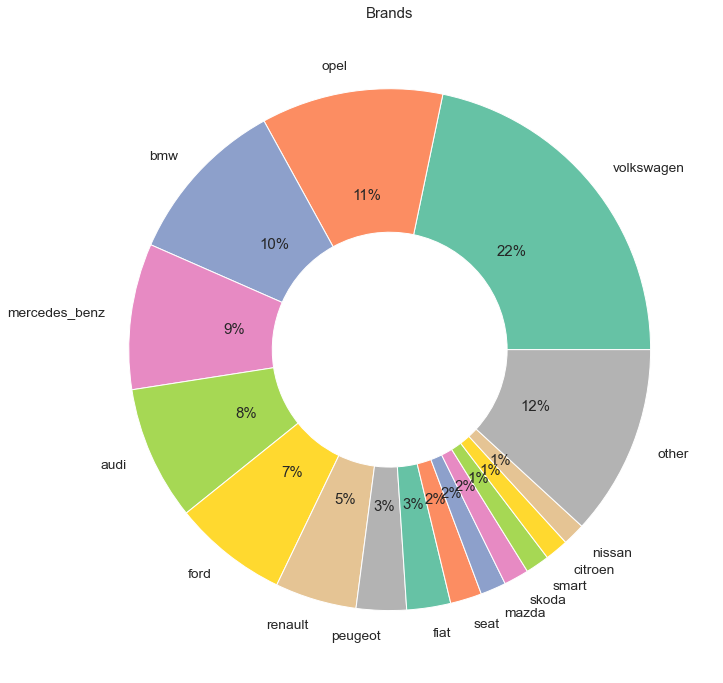

In [46]:
brand_piechart_data = data['Brand'].value_counts()[:15].append(
    pd.Series(data['Brand'].value_counts()[15:].sum(), index=['other']))

brand_piechart_data.plot(kind='pie', 
                         figsize=(12,12), 
                         title='Brands', 
                         ylabel='', 
                         autopct='%1.0f%%', 
                         wedgeprops=dict(width=0.55, edgecolor='w'));

Distribution does not raise any questions. More than a half are German brands.

#### Repaired column

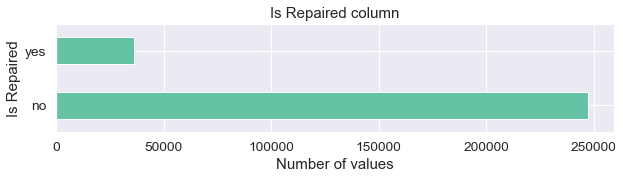

In [47]:
data['Repaired'].value_counts().plot(kind='barh', 
                                     rot=0, 
                                     figsize=(10, 2)).set(xlabel='Number of values', 
                                                         ylabel='Is Repaired',
                                                         title='Is Repaired column');

We have a categorical feature with two values. We can convert it to a boolean type (yes - 1, no - 0). Fill in the gaps with zeros.

#### DateCreated column

In [48]:
(pd.to_datetime(data['DateCreated'])).dt.year.value_counts()

2016    354343
2015        25
2014         1
Name: DateCreated, dtype: int64

Almost all ads were created in 2016.

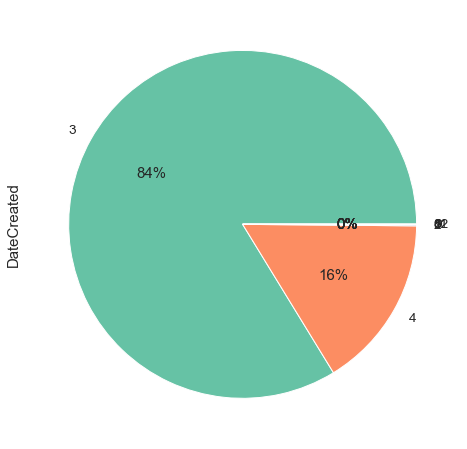

In [49]:
(pd.to_datetime(data['DateCreated'])).dt.month.value_counts().plot(kind='pie', 
                                                                   figsize=(8, 8), 
                                                                   autopct='%1.0f%%');

The vast majority of ads were created in March and April.  
It is unlikely that this feature will be important when training models.

####  NumberOfPictures column

In [50]:
data['NumberOfPictures'].describe()

count    354369.0
mean          0.0
std           0.0
min           0.0
25%           0.0
50%           0.0
75%           0.0
max           0.0
Name: NumberOfPictures, dtype: float64

We don't have actual image data. The sign is not informative, we can delete it.

####  PostalCode column

In [51]:
data['PostalCode'].value_counts()

10115    819
65428    613
66333    343
32257    317
44145    317
        ... 
91801      1
31097      1
82444      1
94359      1
31096      1
Name: PostalCode, Length: 8143, dtype: int64

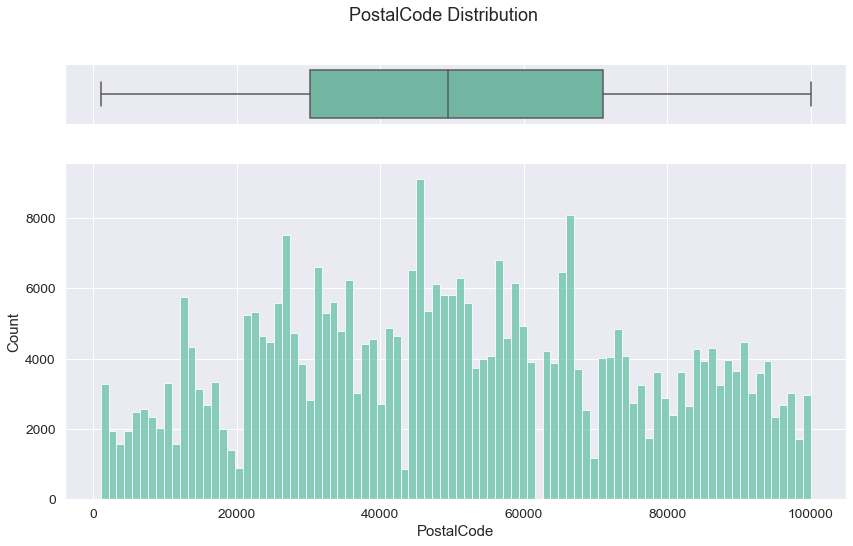

In [52]:
box_hist_plot(data, 
              'PostalCode', 
              'PostalCode Distribution',
              bins=90)

This feature is uninformative by itself. But we can try to make transformations based on this feature. For example, extract the name of the settlement from the index and calculate the frequency of this name in the data. Such a feature may indirectly reflect the possible demand at the location of the specified ad.

####  LasetSeen column

In [53]:
(pd.to_datetime(data['LastSeen'])).dt.year.value_counts()

2016    354369
Name: LastSeen, dtype: int64

In [54]:
(pd.to_datetime(data['LastSeen'])).dt.month.value_counts()

4    200214
3    154155
Name: LastSeen, dtype: int64

In this column, we have data for only two months of 2016. The sign is uninformative. We can delete.

### Summary

1. Data missings. In total, we have five columns with missing values:
    - VehicleType 37490 We can fill in by the most frequently used brand and model.
    - Gearbox 19833 We can fill in by the most frequent by brand and model.
    - Model 19705 We can fill in by brand and year of registration.
    - FuelType 32895 Fill in by the most frequently used brand and model.
    - Repaired 71154 Fill in with zeros (we assume that it is indicated as not being repaired)
2. Data type mismatch
    - Repaired object (convert to bool)
    - Gearbox object (convert to bool)
3. Uninformative features.
    - NumberOfPictures
    - RegistrationMonth
    - LasetSeen
    - DateCreated
    - Datacrawled
4. Very high power values (> 1000 hp). Remove abnormally large values. Abnormally small - refill based on model information.
5. The maximum possible mileage encountered is 150 thousand. km.

##  Data Cleaning and Transformation

Creating functions for feature tramsformation

In [55]:
def feature_processing(data):
    df = data.copy()
        
    # Repaired column bool convertion
    df['Repaired'] = df['Repaired'].apply(lambda x: 1 if x=='yes' else 0).astype('bool')
    
    # Filling data missings
    def mode_imputer(group):
        """The function returns the most frequent value of the array
        if possible, if not, returns 'other'"""
        try:
            return group.mode().iloc[0]
        except:
            return 'other'
    
    
    def median_imputer(group):
        """The function returns the median value of the array if possible,
        if not, returns the median over the power column"""
        try:
            return group.median()
        except:
            return df['Power'].median()
        
    
    # Cleaning data with invalid data
    min_reg_year = df['RegistrationYear'].quantile(q=0.001)
    df = df.loc[(df['RegistrationYear'] < 2016) & (df['RegistrationYear'] >= min_reg_year)]
    
    # Cleaning data with price anomalies
    df = df.loc[(df['Price'] >= 50)]
    
    # Filling missings in Model column by most frequent values by brand and year
    df['Model'] = df.groupby(['Brand', 'RegistrationYear'])['Model'] \
        .apply(lambda x: x.fillna(mode_imputer(x))).astype('category')
    
    # Filling missings in VehicleType column by most frequent value by brand and model
    df['VehicleType'] = df.groupby(['Brand', 'Model'])['VehicleType'] \
        .apply(lambda x: x.fillna(mode_imputer(x))).astype('category')
    
    # Filling missings in FuelType column by most frequent by brand and model
    df['FuelType'] = df.groupby(['Model'])['FuelType'] \
        .apply(lambda x: x.fillna(mode_imputer(x))).astype('category')
    
    # Filling missings in Gearbox - same
    df['Gearbox'] = df.groupby(['Model'])['Gearbox'] \
        .apply(lambda x: x.fillna(mode_imputer(x)))
    # Converting to bool type
    df['GearboxAuto'] = df['Gearbox'].apply(lambda x: 1 if x == 'auto' else 0).astype('bool')
    df.drop('Gearbox', axis=1, inplace=True)
    
    # Filling zero and near-zero values of power
    min_power_above_zero = df[df['Power']>0]['Power'].quantile(q=0.001)
    df.loc[(df['Power'] < min_power_above_zero), 'Power'] = np.nan
    df['Power'] = df.groupby(['Brand'])['Power'].apply(lambda x: x.fillna(median_imputer(x)))
    # Removing onomalies in power column
    power_upper_limit = df['Power'].quantile(q=0.998)
    df = df.loc[df['Power'] < power_upper_limit]
    
    # New feature NeighborsNumber generation
    df['PostalCode'] = df['PostalCode'].astype('str').apply(lambda x: '0' + x if len(x) == 4 else x)
    zip_codes = np.array(df['PostalCode'].unique())
    zip_codes = list(map(lambda x: '0' + x if len(x)==4 else x, zip_codes))
    nomi = pgeocode.Nominatim('de')
    zip_codes_dict = {code: nomi.query_postal_code(code)['community_name'] for code in zip_codes}
    df['community_name'] = df['PostalCode'].apply(lambda x: zip_codes_dict[x] if zip_codes_dict[x] is not np.nan else x)
    df['NeighborsNumber'] = df.groupby('community_name')['DateCrawled'].transform(lambda x: len(x))
    df.drop(['community_name', 'PostalCode'], axis=1, inplace=True)
        
    df['Brand'] = df['Brand'].astype('category')
    
    df.drop_duplicates(inplace=True)
    
    df.drop(['NumberOfPictures', 'DateCreated', 'LastSeen', 'DateCrawled', 'RegistrationMonth'], axis=1, inplace=True)
        
    return df

Converting the data

In [56]:
data_processed = feature_processing(data)

### Exploring Multicollinearity of Features

Let's check if we have multicollinearity in features. The threshold value of the Pearson correlation coefficient is usually in the range of 0.6 - 0.8.

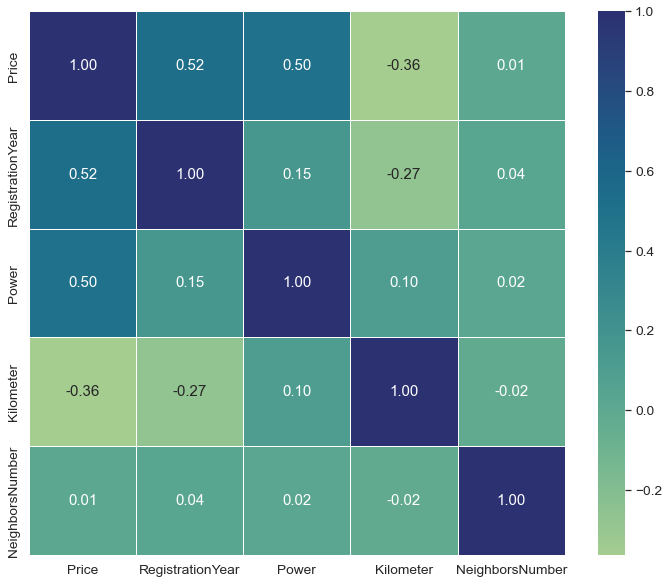

In [57]:
plt.subplots(figsize=(12,10))

numeric_features = [feature for feature in data_processed.columns 
                    if data_processed[feature].dtype in ('float64', 'int64')]

sns.heatmap(data_processed[numeric_features].corr(), annot=True, fmt='.2f', cmap="crest", linewidth=.5);

The maximum observed Pearson's correlation coefficient in the data with quantitative variables is 0.5, which is less than the threshold.

### Phi Correlation Coefficient

In [58]:
data_types = {'Price': 'interval',
              'RegistrationYear':'interval',
              'Power':'interval',
              'Kilometer':'interval',
              'NeighborsNumber':'interval',
              'VehicleType':'categorical',
              'Model':'categorical',
              'FuelType':'categorical',
              'Brand':'categorical',
              'Repaired':'categorical',
              'GearboxAuto':'categorical'}

Interval Features

In [59]:
interval_cols = [col for col, v in data_types.items() 
                 if v=='interval' and col in data_processed.columns]

interval_cols

['Price', 'RegistrationYear', 'Power', 'Kilometer', 'NeighborsNumber']

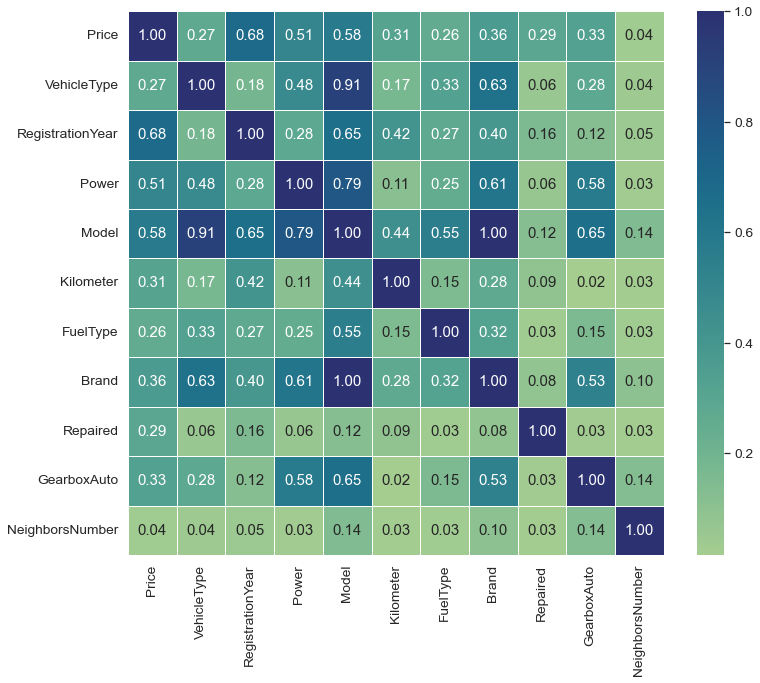

In [60]:
phik_features = data_processed.phik_matrix(interval_cols=interval_cols)
plt.subplots(figsize=(12,10))
sns.heatmap(phik_features, annot=True, fmt='.2f', cmap="crest", linewidth=.5);

The correlation matrix of the phi-coefficient shows that the Model feature is strongly dependent on the Brand, RegistrationYear, Power and GearAuto features. This is clear, because we used the Model feature to fill in the missing values in these columns, and filled in the missing values in the Model based on the Brand feature.

### Summary

The following data transformations were made:
  - Missing values were filled in five columns:
    - Model
    - FuelType
    - VehicleType
    - Gearbox
    - Repaired
  - Fixed abnormally low power values and removed abnormally high ones.
  - Anomalies in the RegistrationYear column have been removed.
  - 5 uninformative signs were removed.
  - Removed duplicated lines
  - A new feature has been generated - NeighborsNumber. This feature indirectly reflects the demand in the area where the ad was placed. The original PostalCode feature has been removed.
  - Transformations of data type of features have been made.
  - No multicollinearity of features were found.

## Preparing samples for model training

At this stage, we will split our dataset into training and test parts.

In [61]:
data_train, data_test = train_test_split(data_processed, test_size=0.3, random_state=RS)

Training set

In [62]:
X_train = data_train.drop('Price', axis=1)

In [63]:
y_train = data_train['Price']

Test set

In [64]:
X_test = data_test.drop('Price', axis=1)

In [65]:
y_test = data_test['Price']

## Models Training

In [66]:
def model_tuning(estimator, params, features, target, poly=False):
    """
    Function for hyperparameters tuning
    """
    numeric_features = [col for col in features.columns if features[col].dtype != 'category']
    categorical_features = [col for col in features.columns if features[col].dtype == 'category']
    
    if poly==False:
        numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
    else:
        numeric_transformer = Pipeline(steps=[('polynom', PolynomialFeatures()),
                                              ('scaler', StandardScaler())])
        
    categorical_transformer = OneHotEncoder(handle_unknown='ignore')
    
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)])

    pipe = Pipeline([('prepr', preprocessor),
                     ('est', estimator)])
    
    random_search = (RandomizedSearchCV(estimator=pipe,
                                        param_distributions=params,
                                        cv=5,
                                        scoring='neg_root_mean_squared_error',
                                        random_state=RS,
                                        n_iter=20,
                                        n_jobs=-1))
    
    rs = random_search.fit(features, target)
    
    
    return rs.best_estimator_, -rs.best_score_    

In [67]:
def catboost_tuning(features, target, params):
    """
    Function for hyperparameters tuning for Catboost model
    """
    X_pool = Pool(data=features, 
                  label=target, 
                  cat_features=['Brand', 'Model', 'VehicleType', 'FuelType'], 
                  feature_names=list(features.columns))
    model_catboost = CatBoostRegressor(loss_function='RMSE')
    rs_catboost = model_catboost.randomized_search(params,
                                                   X_pool,
                                                   cv=5,
                                                   n_iter=20,
                                                   partition_random_seed=RS)
    best_params = rs_catboost['params']
    model_catboost = CatBoostRegressor(**best_params, loss_function='RMSE')
    model_catboost.fit(X_pool, verbose = 1)
    return model_catboost, min(rs_catboost['cv_results']['test-RMSE-mean'])

### LinearSVR Model

Training and hyperparameters tuning of linear support vector machine regression.

In [68]:
params_svr = {'est__C': np.arange(100, 1000, 100),
              'est__max_iter': [500, 1000, 2000]}

In [69]:
model_svr, scores_svr = model_tuning(LinearSVR(random_state=RS), params_svr, X_train, y_train)

In [70]:
f'The maximum value of the RMSE metric on the cross-validation of the LinearSVR model:{scores_svr}'

'The maximum value of the RMSE metric on the cross-validation of the LinearSVR model:2720.0974516620695'

### Ridge Regression Model

Training and selection of parameters for a linear regression model with L2 regularization.

In [71]:
params_ridge = {'est__alpha': np.arange(0.05, 1, 0.05)}

In [72]:
model_ridge, scores_ridge  = model_tuning(Ridge(random_state=RS), params_ridge, X_train, y_train)

In [73]:
f'Best value of RMSE metric on cross-validation of the Ridge Regression model: {scores_ridge}'

'Best value of RMSE metric on cross-validation of the Ridge Regression model: 2621.7909786632376'

### Ridge Regression Model with Polynomial Features

Training and tuning parameters of a ridge regression model with polynomial feature transformation.

In [74]:
params_ridge_poly = {'est__alpha': np.arange(0.05, 1, 0.05),
                'prepr__num__polynom__degree': [2, 3, 4]}

In [75]:
model_poly, scores_poly = model_tuning(Ridge(random_state=RS), params_ridge_poly, X_train, y_train, poly=True)

In [76]:
f'The best value of the RMSE after cross-validation for polynomial regression:{scores_poly}'

'The best value of the RMSE after cross-validation for polynomial regression:2011.2737330594823'

### LightGBM Model

In [77]:
params_lgb = {'est__max_depth': list(range(1, 20, 2)),
              'est__learning_rate': np.arange(0.05, 1, 0.05),
              'est__n_estimators': [50, 100, 150, 200, 250, 300]}

In [78]:
model_lgb, lgb_scores = model_tuning(lgb.LGBMRegressor(random_state=RS), params_lgb, X_train, y_train)

In [79]:
f'The best RMSE value of the LightGBM model: {lgb_scores}'

'The best RMSE value of the LightGBM model: 1607.1427822080414'

### CatBoost Model

In [80]:
params_catboost = {'depth': list(range(1, 22, 3)),
                   'learning_rate': np.arange(0.05, 1, 0.1),
                   'n_estimators': [100, 200, 300]}

In [81]:
model_cb, scores_cb = catboost_tuning(X_train, y_train, params_catboost)

0:	learn: 4333.8640900	test: 4328.5902747	best: 4328.5902747 (0)	total: 161ms	remaining: 15.9s
1:	learn: 3561.2726152	test: 3557.4363057	best: 3557.4363057 (1)	total: 173ms	remaining: 8.5s
2:	learn: 3133.8975651	test: 3125.7281408	best: 3125.7281408 (2)	total: 185ms	remaining: 5.98s
3:	learn: 2962.9844032	test: 2960.1241420	best: 2960.1241420 (3)	total: 196ms	remaining: 4.71s
4:	learn: 2823.7240008	test: 2821.3547007	best: 2821.3547007 (4)	total: 209ms	remaining: 3.96s
5:	learn: 2744.0256257	test: 2746.5006591	best: 2746.5006591 (5)	total: 224ms	remaining: 3.5s
6:	learn: 2674.1029663	test: 2674.5830181	best: 2674.5830181 (6)	total: 234ms	remaining: 3.11s
7:	learn: 2617.2780605	test: 2615.7804924	best: 2615.7804924 (7)	total: 249ms	remaining: 2.87s
8:	learn: 2567.3212509	test: 2567.5701775	best: 2567.5701775 (8)	total: 261ms	remaining: 2.64s
9:	learn: 2535.8477547	test: 2536.3261897	best: 2536.3261897 (9)	total: 272ms	remaining: 2.45s
10:	learn: 2507.5483291	test: 2506.3930091	best: 250

98:	learn: 2199.9631247	test: 2203.3648110	best: 2203.3648110 (98)	total: 1.32s	remaining: 13.4ms
99:	learn: 2199.4224003	test: 2202.8811447	best: 2202.8811447 (99)	total: 1.33s	remaining: 0us

bestTest = 2202.881145
bestIteration = 99

0:	loss: 2202.8811447	best: 2202.8811447 (0)	total: 1.46s	remaining: 27.7s
0:	learn: 4333.8640900	test: 4328.5902747	best: 4328.5902747 (0)	total: 15.7ms	remaining: 3.13s
1:	learn: 3561.2726152	test: 3557.4363057	best: 3557.4363057 (1)	total: 30.4ms	remaining: 3.01s
2:	learn: 3133.8975651	test: 3125.7281408	best: 3125.7281408 (2)	total: 42.7ms	remaining: 2.8s
3:	learn: 2962.9844032	test: 2960.1241420	best: 2960.1241420 (3)	total: 54.9ms	remaining: 2.69s
4:	learn: 2823.7240008	test: 2821.3547007	best: 2821.3547007 (4)	total: 69ms	remaining: 2.69s
5:	learn: 2744.0256257	test: 2746.5006591	best: 2746.5006591 (5)	total: 85.4ms	remaining: 2.76s
6:	learn: 2674.1029663	test: 2674.5830181	best: 2674.5830181 (6)	total: 96.8ms	remaining: 2.67s
7:	learn: 2617.2780

93:	learn: 2202.7156457	test: 2206.3064178	best: 2206.3064178 (93)	total: 1.15s	remaining: 1.3s
94:	learn: 2202.2133324	test: 2205.8516291	best: 2205.8516291 (94)	total: 1.17s	remaining: 1.29s
95:	learn: 2201.4559631	test: 2205.0831637	best: 2205.0831637 (95)	total: 1.18s	remaining: 1.28s
96:	learn: 2200.9549628	test: 2204.6341819	best: 2204.6341819 (96)	total: 1.19s	remaining: 1.26s
97:	learn: 2200.4679936	test: 2203.8808615	best: 2203.8808615 (97)	total: 1.2s	remaining: 1.25s
98:	learn: 2199.9631247	test: 2203.3648110	best: 2203.3648110 (98)	total: 1.22s	remaining: 1.25s
99:	learn: 2199.4224003	test: 2202.8811447	best: 2202.8811447 (99)	total: 1.23s	remaining: 1.23s
100:	learn: 2198.9237699	test: 2202.6164654	best: 2202.6164654 (100)	total: 1.25s	remaining: 1.22s
101:	learn: 2198.4081506	test: 2201.7996194	best: 2201.7996194 (101)	total: 1.26s	remaining: 1.21s
102:	learn: 2197.9466826	test: 2201.4471796	best: 2201.4471796 (102)	total: 1.27s	remaining: 1.19s
103:	learn: 2197.4036505	t

192:	learn: 2169.6322702	test: 2172.7021843	best: 2172.7021843 (192)	total: 2.27s	remaining: 82.5ms
193:	learn: 2169.4122032	test: 2172.4647139	best: 2172.4647139 (193)	total: 2.29s	remaining: 70.7ms
194:	learn: 2169.1661552	test: 2172.0985265	best: 2172.0985265 (194)	total: 2.31s	remaining: 59.3ms
195:	learn: 2168.9543125	test: 2171.9503428	best: 2171.9503428 (195)	total: 2.33s	remaining: 47.5ms
196:	learn: 2168.6666730	test: 2171.6129810	best: 2171.6129810 (196)	total: 2.33s	remaining: 35.6ms
197:	learn: 2168.4457046	test: 2171.4644117	best: 2171.4644117 (197)	total: 2.35s	remaining: 23.7ms
198:	learn: 2168.2164683	test: 2171.2757599	best: 2171.2757599 (198)	total: 2.36s	remaining: 11.8ms
199:	learn: 2167.9934935	test: 2170.9768865	best: 2170.9768865 (199)	total: 2.37s	remaining: 0us

bestTest = 2170.976886
bestIteration = 199

1:	loss: 2170.9768865	best: 2170.9768865 (1)	total: 3.88s	remaining: 34.9s
0:	learn: 5039.7313939	test: 5033.6135622	best: 5033.6135622 (0)	total: 17.6ms	rema

77:	learn: 2211.8441287	test: 2210.1164844	best: 2210.1164844 (77)	total: 846ms	remaining: 2.41s
78:	learn: 2210.9270521	test: 2209.5663679	best: 2209.5663679 (78)	total: 856ms	remaining: 2.4s
79:	learn: 2210.1927414	test: 2208.7771313	best: 2208.7771313 (79)	total: 868ms	remaining: 2.39s
80:	learn: 2209.7125524	test: 2208.3887583	best: 2208.3887583 (80)	total: 879ms	remaining: 2.38s
81:	learn: 2209.1051792	test: 2207.6171351	best: 2207.6171351 (81)	total: 890ms	remaining: 2.37s
82:	learn: 2208.5245508	test: 2207.0732678	best: 2207.0732678 (82)	total: 901ms	remaining: 2.36s
83:	learn: 2207.8748372	test: 2206.5656647	best: 2206.5656647 (83)	total: 912ms	remaining: 2.35s
84:	learn: 2207.2766620	test: 2205.8255407	best: 2205.8255407 (84)	total: 923ms	remaining: 2.33s
85:	learn: 2206.7432992	test: 2205.3253153	best: 2205.3253153 (85)	total: 934ms	remaining: 2.32s
86:	learn: 2206.1910713	test: 2205.2136221	best: 2205.2136221 (86)	total: 944ms	remaining: 2.31s
87:	learn: 2205.6349508	test: 2

165:	learn: 2178.2921636	test: 2177.8464500	best: 2177.8464500 (165)	total: 1.8s	remaining: 1.45s
166:	learn: 2178.0700447	test: 2177.5997196	best: 2177.5997196 (166)	total: 1.81s	remaining: 1.44s
167:	learn: 2177.7835858	test: 2177.2013019	best: 2177.2013019 (167)	total: 1.82s	remaining: 1.43s
168:	learn: 2177.5480931	test: 2177.0939489	best: 2177.0939489 (168)	total: 1.83s	remaining: 1.42s
169:	learn: 2177.3231586	test: 2176.8088313	best: 2176.8088313 (169)	total: 1.84s	remaining: 1.41s
170:	learn: 2177.1307855	test: 2176.7159341	best: 2176.7159341 (170)	total: 1.85s	remaining: 1.4s
171:	learn: 2176.9668432	test: 2176.5136599	best: 2176.5136599 (171)	total: 1.86s	remaining: 1.39s
172:	learn: 2176.7497999	test: 2176.2113251	best: 2176.2113251 (172)	total: 1.87s	remaining: 1.38s
173:	learn: 2176.5459718	test: 2175.8624922	best: 2175.8624922 (173)	total: 1.88s	remaining: 1.36s
174:	learn: 2176.3608571	test: 2175.7819750	best: 2175.7819750 (174)	total: 1.9s	remaining: 1.35s
175:	learn: 2

256:	learn: 2163.5597763	test: 2162.4958807	best: 2162.4958807 (256)	total: 2.77s	remaining: 464ms
257:	learn: 2163.4387791	test: 2162.3888251	best: 2162.3888251 (257)	total: 2.78s	remaining: 453ms
258:	learn: 2163.3320776	test: 2162.3135280	best: 2162.3135280 (258)	total: 2.79s	remaining: 442ms
259:	learn: 2163.1989696	test: 2162.1749523	best: 2162.1749523 (259)	total: 2.8s	remaining: 431ms
260:	learn: 2163.0839142	test: 2162.0755626	best: 2162.0755626 (260)	total: 2.81s	remaining: 421ms
261:	learn: 2162.9481639	test: 2162.0057504	best: 2162.0057504 (261)	total: 2.83s	remaining: 410ms
262:	learn: 2162.8084309	test: 2161.7515952	best: 2161.7515952 (262)	total: 2.84s	remaining: 399ms
263:	learn: 2162.6845392	test: 2161.5628698	best: 2161.5628698 (263)	total: 2.85s	remaining: 388ms
264:	learn: 2162.5505864	test: 2161.4949957	best: 2161.4949957 (264)	total: 2.86s	remaining: 378ms
265:	learn: 2162.4523335	test: 2161.3379818	best: 2161.3379818 (265)	total: 2.87s	remaining: 367ms
266:	learn:

42:	learn: 2250.1898961	test: 2247.1845783	best: 2247.1845783 (42)	total: 474ms	remaining: 2.83s
43:	learn: 2248.7383908	test: 2245.3472344	best: 2245.3472344 (43)	total: 483ms	remaining: 2.81s
44:	learn: 2247.2047406	test: 2244.1294179	best: 2244.1294179 (44)	total: 494ms	remaining: 2.8s
45:	learn: 2245.2277883	test: 2242.3858237	best: 2242.3858237 (45)	total: 504ms	remaining: 2.78s
46:	learn: 2243.3134304	test: 2239.8729736	best: 2239.8729736 (46)	total: 515ms	remaining: 2.77s
47:	learn: 2241.9398431	test: 2238.7627990	best: 2238.7627990 (47)	total: 526ms	remaining: 2.76s
48:	learn: 2240.5510740	test: 2237.4640640	best: 2237.4640640 (48)	total: 538ms	remaining: 2.75s
49:	learn: 2239.3133432	test: 2236.3442940	best: 2236.3442940 (49)	total: 549ms	remaining: 2.75s
50:	learn: 2238.1487930	test: 2235.6390703	best: 2235.6390703 (50)	total: 560ms	remaining: 2.73s
51:	learn: 2237.0250214	test: 2234.5473616	best: 2234.5473616 (51)	total: 571ms	remaining: 2.73s
52:	learn: 2235.1051319	test: 2

133:	learn: 2188.7807768	test: 2188.3264311	best: 2188.3264311 (133)	total: 1.45s	remaining: 1.8s
134:	learn: 2188.5111640	test: 2188.0393819	best: 2188.0393819 (134)	total: 1.46s	remaining: 1.79s
135:	learn: 2188.2402887	test: 2187.7802523	best: 2187.7802523 (135)	total: 1.47s	remaining: 1.78s
136:	learn: 2187.9461940	test: 2187.4877399	best: 2187.4877399 (136)	total: 1.48s	remaining: 1.76s
137:	learn: 2187.6451134	test: 2187.2936294	best: 2187.2936294 (137)	total: 1.49s	remaining: 1.75s
138:	learn: 2187.3605293	test: 2186.8149533	best: 2186.8149533 (138)	total: 1.5s	remaining: 1.74s
139:	learn: 2187.0704177	test: 2186.5909958	best: 2186.5909958 (139)	total: 1.51s	remaining: 1.73s
140:	learn: 2186.8862763	test: 2186.3142018	best: 2186.3142018 (140)	total: 1.52s	remaining: 1.72s
141:	learn: 2186.6285632	test: 2186.0879655	best: 2186.0879655 (141)	total: 1.54s	remaining: 1.71s
142:	learn: 2186.2072533	test: 2185.8825457	best: 2185.8825457 (142)	total: 1.55s	remaining: 1.7s
143:	learn: 2

223:	learn: 2168.7700644	test: 2169.2306166	best: 2169.2306166 (223)	total: 2.4s	remaining: 816ms
224:	learn: 2168.6139503	test: 2169.1508505	best: 2169.1508505 (224)	total: 2.41s	remaining: 805ms
225:	learn: 2168.5303916	test: 2169.0961207	best: 2169.0961207 (225)	total: 2.42s	remaining: 794ms
226:	learn: 2168.3828664	test: 2168.8643561	best: 2168.8643561 (226)	total: 2.44s	remaining: 783ms
227:	learn: 2168.2108852	test: 2168.7970844	best: 2168.7970844 (227)	total: 2.45s	remaining: 773ms
228:	learn: 2168.0634484	test: 2168.6101452	best: 2168.6101452 (228)	total: 2.46s	remaining: 762ms
229:	learn: 2167.8604270	test: 2168.5044531	best: 2168.5044531 (229)	total: 2.47s	remaining: 751ms
230:	learn: 2167.7051872	test: 2168.2518356	best: 2168.2518356 (230)	total: 2.48s	remaining: 741ms
231:	learn: 2167.5558998	test: 2168.2006245	best: 2168.2006245 (231)	total: 2.49s	remaining: 730ms
232:	learn: 2167.4049646	test: 2167.9379468	best: 2167.9379468 (232)	total: 2.5s	remaining: 719ms
233:	learn: 

12:	learn: 1999.6705589	test: 2008.1423342	best: 2008.1423342 (12)	total: 380ms	remaining: 2.54s
13:	learn: 1980.0019287	test: 1988.2847717	best: 1988.2847717 (13)	total: 404ms	remaining: 2.48s
14:	learn: 1965.1137318	test: 1972.9898814	best: 1972.9898814 (14)	total: 430ms	remaining: 2.43s
15:	learn: 1946.2400535	test: 1955.8927978	best: 1955.8927978 (15)	total: 453ms	remaining: 2.38s
16:	learn: 1936.9771924	test: 1947.5191555	best: 1947.5191555 (16)	total: 477ms	remaining: 2.33s
17:	learn: 1921.4795292	test: 1926.5603213	best: 1926.5603213 (17)	total: 501ms	remaining: 2.28s
18:	learn: 1912.0293261	test: 1917.7077497	best: 1917.7077497 (18)	total: 530ms	remaining: 2.26s
19:	learn: 1903.6027049	test: 1909.9014790	best: 1909.9014790 (19)	total: 562ms	remaining: 2.25s
20:	learn: 1896.0823404	test: 1903.7596859	best: 1903.7596859 (20)	total: 587ms	remaining: 2.21s
21:	learn: 1889.9039080	test: 1896.9779730	best: 1896.9779730 (21)	total: 625ms	remaining: 2.21s
22:	learn: 1884.0594123	test: 

1:	learn: 3154.9852148	test: 3150.2843086	best: 3150.2843086 (1)	total: 89.7ms	remaining: 8.88s
2:	learn: 2612.4997764	test: 2611.6287390	best: 2611.6287390 (2)	total: 136ms	remaining: 8.94s
3:	learn: 2369.9659189	test: 2369.8266530	best: 2369.8266530 (3)	total: 178ms	remaining: 8.74s
4:	learn: 2211.6045018	test: 2215.8448631	best: 2215.8448631 (4)	total: 228ms	remaining: 8.88s
5:	learn: 2144.5979498	test: 2148.9578490	best: 2148.9578490 (5)	total: 277ms	remaining: 8.96s
6:	learn: 2107.1785191	test: 2112.9414880	best: 2112.9414880 (6)	total: 328ms	remaining: 9.05s
7:	learn: 2065.3319865	test: 2072.2464615	best: 2072.2464615 (7)	total: 389ms	remaining: 9.33s
8:	learn: 2045.2472576	test: 2048.7460775	best: 2048.7460775 (8)	total: 442ms	remaining: 9.39s
9:	learn: 2021.2905820	test: 2023.2085987	best: 2023.2085987 (9)	total: 491ms	remaining: 9.34s
10:	learn: 2005.4908481	test: 2008.6105979	best: 2008.6105979 (10)	total: 543ms	remaining: 9.32s
11:	learn: 1992.6516531	test: 1996.3416382	best

90:	learn: 1730.3007911	test: 1751.5875530	best: 1751.5875530 (90)	total: 4.31s	remaining: 5.16s
91:	learn: 1729.4817026	test: 1750.3912462	best: 1750.3912462 (91)	total: 4.36s	remaining: 5.12s
92:	learn: 1728.6436851	test: 1749.7916736	best: 1749.7916736 (92)	total: 4.41s	remaining: 5.08s
93:	learn: 1727.9406728	test: 1749.5069744	best: 1749.5069744 (93)	total: 4.46s	remaining: 5.03s
94:	learn: 1727.6457907	test: 1749.2256931	best: 1749.2256931 (94)	total: 4.52s	remaining: 5s
95:	learn: 1727.1225650	test: 1748.7577518	best: 1748.7577518 (95)	total: 4.57s	remaining: 4.95s
96:	learn: 1726.0200459	test: 1747.4560233	best: 1747.4560233 (96)	total: 4.62s	remaining: 4.91s
97:	learn: 1725.4904928	test: 1747.1533471	best: 1747.1533471 (97)	total: 4.66s	remaining: 4.85s
98:	learn: 1724.2386884	test: 1745.9507667	best: 1745.9507667 (98)	total: 4.71s	remaining: 4.81s
99:	learn: 1722.3470599	test: 1744.3007069	best: 1744.3007069 (99)	total: 4.76s	remaining: 4.76s
100:	learn: 1720.6243389	test: 17

177:	learn: 1674.9040904	test: 1710.3097251	best: 1710.3097251 (177)	total: 8.65s	remaining: 1.07s
178:	learn: 1674.4829076	test: 1709.9941299	best: 1709.9941299 (178)	total: 8.7s	remaining: 1.02s
179:	learn: 1673.9244643	test: 1709.8894581	best: 1709.8894581 (179)	total: 8.74s	remaining: 971ms
180:	learn: 1673.7764752	test: 1710.3164821	best: 1709.8894581 (179)	total: 8.79s	remaining: 923ms
181:	learn: 1673.5709785	test: 1710.1556203	best: 1709.8894581 (179)	total: 8.86s	remaining: 876ms
182:	learn: 1673.1869680	test: 1709.7254708	best: 1709.7254708 (182)	total: 8.91s	remaining: 828ms
183:	learn: 1672.7744306	test: 1709.5761232	best: 1709.5761232 (183)	total: 8.98s	remaining: 781ms
184:	learn: 1672.4279606	test: 1709.3466408	best: 1709.3466408 (184)	total: 9.04s	remaining: 733ms
185:	learn: 1671.7754385	test: 1708.6922025	best: 1708.6922025 (185)	total: 9.09s	remaining: 684ms
186:	learn: 1671.3401310	test: 1708.3043638	best: 1708.3043638 (186)	total: 9.13s	remaining: 635ms
187:	learn:

61:	learn: 1746.8758338	test: 1773.4305648	best: 1773.4305648 (61)	total: 3.17s	remaining: 7.06s
62:	learn: 1745.2973429	test: 1771.8649999	best: 1771.8649999 (62)	total: 3.22s	remaining: 7.01s
63:	learn: 1744.0124393	test: 1771.2930403	best: 1771.2930403 (63)	total: 3.28s	remaining: 6.97s
64:	learn: 1742.5608092	test: 1770.7981455	best: 1770.7981455 (64)	total: 3.33s	remaining: 6.92s
65:	learn: 1740.8948216	test: 1768.6201064	best: 1768.6201064 (65)	total: 3.38s	remaining: 6.87s
66:	learn: 1738.8954734	test: 1768.0115999	best: 1768.0115999 (66)	total: 3.43s	remaining: 6.81s
67:	learn: 1738.0835029	test: 1766.4698087	best: 1766.4698087 (67)	total: 3.5s	remaining: 6.8s
68:	learn: 1736.7574857	test: 1765.8252650	best: 1765.8252650 (68)	total: 3.58s	remaining: 6.8s
69:	learn: 1735.2143818	test: 1764.4876578	best: 1764.4876578 (69)	total: 3.65s	remaining: 6.78s
70:	learn: 1733.8761808	test: 1761.9101179	best: 1761.9101179 (70)	total: 3.71s	remaining: 6.74s
71:	learn: 1732.6219927	test: 176

148:	learn: 1671.1010736	test: 1720.0628976	best: 1720.0628976 (148)	total: 7.66s	remaining: 2.62s
149:	learn: 1670.4149655	test: 1719.4872559	best: 1719.4872559 (149)	total: 7.71s	remaining: 2.57s
150:	learn: 1670.0332058	test: 1719.6493893	best: 1719.4872559 (149)	total: 7.76s	remaining: 2.52s
151:	learn: 1669.4295197	test: 1719.4857572	best: 1719.4857572 (151)	total: 7.8s	remaining: 2.46s
152:	learn: 1668.6304030	test: 1718.4668377	best: 1718.4668377 (152)	total: 7.84s	remaining: 2.41s
153:	learn: 1668.0846769	test: 1718.5171455	best: 1718.4668377 (152)	total: 7.88s	remaining: 2.35s
154:	learn: 1667.8837298	test: 1718.1282366	best: 1718.1282366 (154)	total: 7.93s	remaining: 2.3s
155:	learn: 1667.4610004	test: 1718.2379385	best: 1718.1282366 (154)	total: 7.98s	remaining: 2.25s
156:	learn: 1667.1048100	test: 1718.0590689	best: 1718.0590689 (156)	total: 8.03s	remaining: 2.2s
157:	learn: 1666.4892861	test: 1717.5092010	best: 1717.5092010 (157)	total: 8.06s	remaining: 2.14s
158:	learn: 1

32:	learn: 1694.8325921	test: 1738.1003947	best: 1738.1003947 (32)	total: 3.12s	remaining: 15.8s
33:	learn: 1689.9790392	test: 1735.3515301	best: 1735.3515301 (33)	total: 3.26s	remaining: 15.9s
34:	learn: 1687.5029842	test: 1735.4876952	best: 1735.3515301 (33)	total: 3.37s	remaining: 15.9s
35:	learn: 1684.7767616	test: 1734.4327389	best: 1734.4327389 (35)	total: 3.45s	remaining: 15.7s
36:	learn: 1681.2857273	test: 1733.6973746	best: 1733.6973746 (36)	total: 3.56s	remaining: 15.7s
37:	learn: 1678.0807295	test: 1732.2740745	best: 1732.2740745 (37)	total: 3.63s	remaining: 15.5s
38:	learn: 1675.8314605	test: 1731.8330788	best: 1731.8330788 (38)	total: 3.72s	remaining: 15.4s
39:	learn: 1673.7013584	test: 1730.9761633	best: 1730.9761633 (39)	total: 3.84s	remaining: 15.4s
40:	learn: 1670.5679687	test: 1730.4385742	best: 1730.4385742 (40)	total: 3.96s	remaining: 15.4s
41:	learn: 1668.4143621	test: 1730.2063195	best: 1730.2063195 (41)	total: 4.09s	remaining: 15.4s
42:	learn: 1665.9164640	test: 

119:	learn: 1538.4910568	test: 1684.5965197	best: 1684.5965197 (119)	total: 10.8s	remaining: 7.19s
120:	learn: 1537.7107860	test: 1683.8122064	best: 1683.8122064 (120)	total: 10.9s	remaining: 7.09s
121:	learn: 1536.4223195	test: 1682.4333052	best: 1682.4333052 (121)	total: 11s	remaining: 7s
122:	learn: 1535.8710039	test: 1682.5170857	best: 1682.4333052 (121)	total: 11s	remaining: 6.91s
123:	learn: 1534.8901330	test: 1682.2644775	best: 1682.2644775 (123)	total: 11.1s	remaining: 6.81s
124:	learn: 1534.6382752	test: 1682.3584750	best: 1682.2644775 (123)	total: 11.2s	remaining: 6.72s
125:	learn: 1533.3193121	test: 1682.0511437	best: 1682.0511437 (125)	total: 11.3s	remaining: 6.62s
126:	learn: 1531.5936182	test: 1681.7104275	best: 1681.7104275 (126)	total: 11.4s	remaining: 6.53s
127:	learn: 1530.5592345	test: 1681.1198833	best: 1681.1198833 (127)	total: 11.4s	remaining: 6.43s
128:	learn: 1529.5484194	test: 1681.9729282	best: 1681.1198833 (127)	total: 11.5s	remaining: 6.35s
129:	learn: 1528.

1:	learn: 2232.2224707	test: 2234.5111039	best: 2234.5111039 (1)	total: 206ms	remaining: 20.4s
2:	learn: 2135.6917495	test: 2144.2877887	best: 2144.2877887 (2)	total: 318ms	remaining: 20.9s
3:	learn: 2041.2926511	test: 2049.6656626	best: 2049.6656626 (3)	total: 403ms	remaining: 19.8s
4:	learn: 1994.4777944	test: 1992.0032118	best: 1992.0032118 (4)	total: 487ms	remaining: 19s
5:	learn: 1967.6829461	test: 1968.3787216	best: 1968.3787216 (5)	total: 588ms	remaining: 19s
6:	learn: 1924.5305153	test: 1928.9519144	best: 1928.9519144 (6)	total: 695ms	remaining: 19.2s
7:	learn: 1896.1876114	test: 1899.2239943	best: 1899.2239943 (7)	total: 775ms	remaining: 18.6s
8:	learn: 1875.8862191	test: 1886.1979646	best: 1886.1979646 (8)	total: 874ms	remaining: 18.5s
9:	learn: 1864.8869552	test: 1876.7779573	best: 1876.7779573 (9)	total: 964ms	remaining: 18.3s
10:	learn: 1847.7220708	test: 1857.8134339	best: 1857.8134339 (10)	total: 1.05s	remaining: 18.1s
11:	learn: 1833.5494176	test: 1845.5788018	best: 184

88:	learn: 1576.3625950	test: 1692.4234450	best: 1692.4234450 (88)	total: 8.28s	remaining: 10.3s
89:	learn: 1574.4079208	test: 1691.3126889	best: 1691.3126889 (89)	total: 8.35s	remaining: 10.2s
90:	learn: 1572.4109146	test: 1691.7034743	best: 1691.3126889 (89)	total: 8.43s	remaining: 10.1s
91:	learn: 1571.0409564	test: 1691.8098994	best: 1691.3126889 (89)	total: 8.5s	remaining: 9.98s
92:	learn: 1570.3538269	test: 1691.6573482	best: 1691.3126889 (89)	total: 8.58s	remaining: 9.87s
93:	learn: 1569.3085387	test: 1691.8280149	best: 1691.3126889 (89)	total: 8.67s	remaining: 9.78s
94:	learn: 1568.0417562	test: 1690.8262069	best: 1690.8262069 (94)	total: 8.74s	remaining: 9.66s
95:	learn: 1566.8061023	test: 1689.9332019	best: 1689.9332019 (95)	total: 8.82s	remaining: 9.56s
96:	learn: 1566.0682921	test: 1689.1407141	best: 1689.1407141 (96)	total: 8.9s	remaining: 9.45s
97:	learn: 1564.7820079	test: 1688.0743166	best: 1688.0743166 (97)	total: 8.99s	remaining: 9.36s
98:	learn: 1563.6563671	test: 16

173:	learn: 1487.0464666	test: 1669.7132097	best: 1669.7132097 (173)	total: 16s	remaining: 2.38s
174:	learn: 1486.6397514	test: 1669.6138471	best: 1669.6138471 (174)	total: 16s	remaining: 2.29s
175:	learn: 1485.7979200	test: 1669.4461680	best: 1669.4461680 (175)	total: 16.1s	remaining: 2.2s
176:	learn: 1485.1265020	test: 1669.2299402	best: 1669.2299402 (176)	total: 16.2s	remaining: 2.11s
177:	learn: 1484.3136554	test: 1668.9906528	best: 1668.9906528 (177)	total: 16.3s	remaining: 2.02s
178:	learn: 1483.5798008	test: 1669.2885246	best: 1668.9906528 (177)	total: 16.4s	remaining: 1.93s
179:	learn: 1483.1503313	test: 1668.9725755	best: 1668.9725755 (179)	total: 16.5s	remaining: 1.84s
180:	learn: 1482.5334139	test: 1669.0081890	best: 1668.9725755 (179)	total: 16.7s	remaining: 1.75s
181:	learn: 1481.5093170	test: 1669.2663977	best: 1668.9725755 (179)	total: 16.8s	remaining: 1.66s
182:	learn: 1480.9828362	test: 1669.2562647	best: 1668.9725755 (179)	total: 16.8s	remaining: 1.56s
183:	learn: 148

58:	learn: 1657.0372352	test: 1704.8390329	best: 1704.8390329 (58)	total: 3.72s	remaining: 2.58s
59:	learn: 1654.0429478	test: 1702.3728658	best: 1702.3728658 (59)	total: 3.78s	remaining: 2.52s
60:	learn: 1651.7711606	test: 1700.9373545	best: 1700.9373545 (60)	total: 3.84s	remaining: 2.45s
61:	learn: 1650.0286664	test: 1700.3957426	best: 1700.3957426 (61)	total: 3.9s	remaining: 2.39s
62:	learn: 1647.9021229	test: 1699.3173095	best: 1699.3173095 (62)	total: 3.96s	remaining: 2.32s
63:	learn: 1646.0097543	test: 1698.5953651	best: 1698.5953651 (63)	total: 4.02s	remaining: 2.26s
64:	learn: 1643.1459581	test: 1696.3020155	best: 1696.3020155 (64)	total: 4.08s	remaining: 2.2s
65:	learn: 1640.9754377	test: 1694.8943347	best: 1694.8943347 (65)	total: 4.14s	remaining: 2.13s
66:	learn: 1639.7335845	test: 1694.4085397	best: 1694.4085397 (66)	total: 4.21s	remaining: 2.07s
67:	learn: 1637.8640361	test: 1693.0635882	best: 1693.0635882 (67)	total: 4.27s	remaining: 2.01s
68:	learn: 1636.9013427	test: 16

43:	learn: 1530.4282025	test: 1656.2443268	best: 1655.7936030 (42)	total: 5.28s	remaining: 18.7s
44:	learn: 1527.7713796	test: 1655.6832230	best: 1655.6832230 (44)	total: 5.42s	remaining: 18.7s
45:	learn: 1524.1966254	test: 1654.8361902	best: 1654.8361902 (45)	total: 5.56s	remaining: 18.6s
46:	learn: 1520.9182731	test: 1653.7193520	best: 1653.7193520 (46)	total: 5.68s	remaining: 18.5s
47:	learn: 1518.0728186	test: 1654.3715765	best: 1653.7193520 (46)	total: 5.8s	remaining: 18.4s
48:	learn: 1514.7871669	test: 1654.1033269	best: 1653.7193520 (46)	total: 5.92s	remaining: 18.3s
49:	learn: 1513.0786992	test: 1653.7023274	best: 1653.7023274 (49)	total: 6.06s	remaining: 18.2s
50:	learn: 1508.7140500	test: 1651.5176102	best: 1651.5176102 (50)	total: 6.16s	remaining: 18s
51:	learn: 1507.3020054	test: 1651.8380438	best: 1651.5176102 (50)	total: 6.28s	remaining: 17.9s
52:	learn: 1504.8276711	test: 1651.2764866	best: 1651.2764866 (52)	total: 6.41s	remaining: 17.8s
53:	learn: 1503.2750764	test: 165

129:	learn: 1378.0877035	test: 1634.1853798	best: 1634.1853798 (129)	total: 15.9s	remaining: 8.57s
130:	learn: 1376.1423517	test: 1634.0243035	best: 1634.0243035 (130)	total: 16s	remaining: 8.45s
131:	learn: 1375.4242918	test: 1633.9464270	best: 1633.9464270 (131)	total: 16.2s	remaining: 8.33s
132:	learn: 1374.8867660	test: 1634.0651391	best: 1633.9464270 (131)	total: 16.3s	remaining: 8.2s
133:	learn: 1373.5167952	test: 1633.7604511	best: 1633.7604511 (133)	total: 16.4s	remaining: 8.08s
134:	learn: 1371.2080547	test: 1634.0645004	best: 1633.7604511 (133)	total: 16.5s	remaining: 7.97s
135:	learn: 1370.7418661	test: 1634.2022368	best: 1633.7604511 (133)	total: 16.7s	remaining: 7.85s
136:	learn: 1369.1207467	test: 1634.4334455	best: 1633.7604511 (133)	total: 16.8s	remaining: 7.73s
137:	learn: 1367.3633161	test: 1634.6927858	best: 1633.7604511 (133)	total: 16.9s	remaining: 7.6s
138:	learn: 1366.0773482	test: 1634.8674841	best: 1633.7604511 (133)	total: 17s	remaining: 7.47s
139:	learn: 1364

13:	learn: 1598.3359244	test: 1724.6422200	best: 1724.6422200 (13)	total: 2.09s	remaining: 12.8s
14:	learn: 1577.8570779	test: 1715.3151915	best: 1715.3151915 (14)	total: 2.24s	remaining: 12.7s
15:	learn: 1562.8730793	test: 1708.1287298	best: 1708.1287298 (15)	total: 2.39s	remaining: 12.5s
16:	learn: 1549.8957106	test: 1705.0730223	best: 1705.0730223 (16)	total: 2.53s	remaining: 12.4s
17:	learn: 1531.6922938	test: 1700.9433860	best: 1700.9433860 (17)	total: 2.69s	remaining: 12.3s
18:	learn: 1525.8983032	test: 1701.4536084	best: 1700.9433860 (17)	total: 2.86s	remaining: 12.2s
19:	learn: 1512.3715653	test: 1699.0768590	best: 1699.0768590 (19)	total: 3.01s	remaining: 12.1s
20:	learn: 1503.1620777	test: 1696.4565871	best: 1696.4565871 (20)	total: 3.16s	remaining: 11.9s
21:	learn: 1488.0701910	test: 1688.9930850	best: 1688.9930850 (21)	total: 3.32s	remaining: 11.8s
22:	learn: 1480.3245913	test: 1684.7707220	best: 1684.7707220 (22)	total: 3.46s	remaining: 11.6s
23:	learn: 1476.6240958	test: 

98:	learn: 1164.8846462	test: 1676.0483515	best: 1669.4713288 (67)	total: 15.7s	remaining: 158ms
99:	learn: 1159.1318208	test: 1676.0269640	best: 1669.4713288 (67)	total: 15.8s	remaining: 0us

bestTest = 1669.471329
bestIteration = 67

11:	loss: 1669.4713288	best: 1628.0705090 (10)	total: 1m 57s	remaining: 1m 18s
0:	learn: 2662.7320932	test: 2678.4713854	best: 2678.4713854 (0)	total: 64.6ms	remaining: 6.39s
1:	learn: 2165.3214459	test: 2185.7801283	best: 2185.7801283 (1)	total: 232ms	remaining: 11.4s
2:	learn: 1934.6938686	test: 1971.0962555	best: 1971.0962555 (2)	total: 388ms	remaining: 12.5s
3:	learn: 1863.3420081	test: 1899.8656620	best: 1899.8656620 (3)	total: 535ms	remaining: 12.8s
4:	learn: 1794.7910113	test: 1838.0338447	best: 1838.0338447 (4)	total: 689ms	remaining: 13.1s
5:	learn: 1753.5156735	test: 1805.7677904	best: 1805.7677904 (5)	total: 846ms	remaining: 13.2s
6:	learn: 1724.6173078	test: 1784.7744013	best: 1784.7744013 (6)	total: 997ms	remaining: 13.2s
7:	learn: 1702.9255

83:	learn: 1189.1549005	test: 1710.7550331	best: 1703.8303107 (63)	total: 13.2s	remaining: 2.51s
84:	learn: 1185.3997235	test: 1711.0891755	best: 1703.8303107 (63)	total: 13.5s	remaining: 2.38s
85:	learn: 1181.5716027	test: 1711.1895822	best: 1703.8303107 (63)	total: 13.7s	remaining: 2.22s
86:	learn: 1177.7801866	test: 1711.6514292	best: 1703.8303107 (63)	total: 13.8s	remaining: 2.07s
87:	learn: 1177.7362710	test: 1711.6823053	best: 1703.8303107 (63)	total: 14s	remaining: 1.91s
88:	learn: 1176.8719378	test: 1712.1339508	best: 1703.8303107 (63)	total: 14.2s	remaining: 1.75s
89:	learn: 1174.7846926	test: 1712.5236420	best: 1703.8303107 (63)	total: 14.3s	remaining: 1.59s
90:	learn: 1172.7460362	test: 1712.7641733	best: 1703.8303107 (63)	total: 14.5s	remaining: 1.43s
91:	learn: 1170.5382836	test: 1712.7763527	best: 1703.8303107 (63)	total: 14.6s	remaining: 1.27s
92:	learn: 1169.4391334	test: 1713.1299129	best: 1703.8303107 (63)	total: 14.8s	remaining: 1.11s
93:	learn: 1167.0413935	test: 17

67:	learn: 1261.3670229	test: 1663.3820347	best: 1663.3775888 (65)	total: 17.8s	remaining: 34.6s
68:	learn: 1257.8736426	test: 1662.5573821	best: 1662.5573821 (68)	total: 18.1s	remaining: 34.3s
69:	learn: 1254.1711306	test: 1662.6106616	best: 1662.5573821 (68)	total: 18.3s	remaining: 34s
70:	learn: 1252.6292440	test: 1662.8537794	best: 1662.5573821 (68)	total: 18.6s	remaining: 33.7s
71:	learn: 1246.1041882	test: 1662.1885424	best: 1662.1885424 (71)	total: 18.9s	remaining: 33.5s
72:	learn: 1243.6338338	test: 1662.4550125	best: 1662.1885424 (71)	total: 19.1s	remaining: 33.3s
73:	learn: 1239.9839380	test: 1661.2909913	best: 1661.2909913 (73)	total: 19.4s	remaining: 33s
74:	learn: 1235.9079789	test: 1660.2251005	best: 1660.2251005 (74)	total: 19.6s	remaining: 32.7s
75:	learn: 1232.6319547	test: 1660.0810245	best: 1660.0810245 (75)	total: 19.9s	remaining: 32.4s
76:	learn: 1231.0283180	test: 1659.7794301	best: 1659.7794301 (76)	total: 20.2s	remaining: 32.2s
77:	learn: 1228.0475655	test: 1659

152:	learn: 1081.2131751	test: 1668.4990222	best: 1658.9530964 (86)	total: 39.9s	remaining: 12.2s
153:	learn: 1080.2687944	test: 1667.9790006	best: 1658.9530964 (86)	total: 40.2s	remaining: 12s
154:	learn: 1078.1684654	test: 1668.0402674	best: 1658.9530964 (86)	total: 40.4s	remaining: 11.7s
155:	learn: 1076.5644757	test: 1668.1437433	best: 1658.9530964 (86)	total: 40.7s	remaining: 11.5s
156:	learn: 1075.4909505	test: 1668.4583035	best: 1658.9530964 (86)	total: 40.9s	remaining: 11.2s
157:	learn: 1073.0641833	test: 1668.3504357	best: 1658.9530964 (86)	total: 41.1s	remaining: 10.9s
158:	learn: 1070.7252531	test: 1668.3146277	best: 1658.9530964 (86)	total: 41.4s	remaining: 10.7s
159:	learn: 1069.7076661	test: 1668.2639586	best: 1658.9530964 (86)	total: 41.6s	remaining: 10.4s
160:	learn: 1068.3709749	test: 1668.2469968	best: 1658.9530964 (86)	total: 41.8s	remaining: 10.1s
161:	learn: 1064.3600785	test: 1667.8189153	best: 1658.9530964 (86)	total: 42.1s	remaining: 9.87s
162:	learn: 1062.34600

36:	learn: 1438.3053659	test: 1648.8321290	best: 1648.8321290 (36)	total: 30.9s	remaining: 52.6s
37:	learn: 1433.5177887	test: 1648.8475334	best: 1648.8321290 (36)	total: 31.7s	remaining: 51.8s
38:	learn: 1427.6666090	test: 1648.0752444	best: 1648.0752444 (38)	total: 32.6s	remaining: 51s
39:	learn: 1424.5237759	test: 1647.4889887	best: 1647.4889887 (39)	total: 33.5s	remaining: 50.2s
40:	learn: 1420.6359372	test: 1646.6265065	best: 1646.6265065 (40)	total: 34.3s	remaining: 49.4s
41:	learn: 1410.3507308	test: 1644.6675962	best: 1644.6675962 (41)	total: 35.2s	remaining: 48.6s
42:	learn: 1404.5451761	test: 1643.3157017	best: 1643.3157017 (42)	total: 36.1s	remaining: 47.8s
43:	learn: 1397.7439188	test: 1641.6281309	best: 1641.6281309 (43)	total: 37s	remaining: 47.1s
44:	learn: 1391.5704607	test: 1640.6533965	best: 1640.6533965 (44)	total: 37.9s	remaining: 46.3s
45:	learn: 1385.8017677	test: 1639.2819747	best: 1639.2819747 (45)	total: 38.8s	remaining: 45.5s
46:	learn: 1376.8568970	test: 1638

20:	learn: 1490.2256358	test: 1677.0203688	best: 1677.0203688 (20)	total: 16.6s	remaining: 1m 2s
21:	learn: 1484.3067903	test: 1675.5476563	best: 1675.5476563 (21)	total: 17.6s	remaining: 1m 2s
22:	learn: 1476.0120710	test: 1672.5745704	best: 1672.5745704 (22)	total: 18.5s	remaining: 1m 2s
23:	learn: 1463.1365207	test: 1667.4703089	best: 1667.4703089 (23)	total: 19.4s	remaining: 1m 1s
24:	learn: 1453.0568534	test: 1665.2843165	best: 1665.2843165 (24)	total: 20.3s	remaining: 1m
25:	learn: 1438.9355476	test: 1660.5054438	best: 1660.5054438 (25)	total: 21.1s	remaining: 1m
26:	learn: 1427.2314103	test: 1659.0466174	best: 1659.0466174 (26)	total: 22s	remaining: 59.4s
27:	learn: 1413.5940626	test: 1654.2247449	best: 1654.2247449 (27)	total: 22.8s	remaining: 58.7s
28:	learn: 1408.8861159	test: 1654.0014362	best: 1654.0014362 (28)	total: 23.7s	remaining: 58s
29:	learn: 1400.5980969	test: 1649.6429420	best: 1649.6429420 (29)	total: 24.6s	remaining: 57.4s
30:	learn: 1386.2554808	test: 1647.43871

4:	learn: 2472.8497889	test: 2512.2604589	best: 2512.2604589 (4)	total: 5.29s	remaining: 5m 12s
5:	learn: 2215.5314899	test: 2266.6343779	best: 2266.6343779 (5)	total: 6.37s	remaining: 5m 11s
6:	learn: 2045.1002191	test: 2107.1882527	best: 2107.1882527 (6)	total: 7.46s	remaining: 5m 12s
7:	learn: 1915.8548273	test: 1986.2545097	best: 1986.2545097 (7)	total: 8.49s	remaining: 5m 10s
8:	learn: 1827.2583259	test: 1906.7559022	best: 1906.7559022 (8)	total: 9.56s	remaining: 5m 8s
9:	learn: 1765.0824752	test: 1853.6382403	best: 1853.6382403 (9)	total: 10.6s	remaining: 5m 7s
10:	learn: 1716.6192844	test: 1812.7135897	best: 1812.7135897 (10)	total: 11.7s	remaining: 5m 6s
11:	learn: 1676.6689620	test: 1780.5876142	best: 1780.5876142 (11)	total: 12.7s	remaining: 5m 5s
12:	learn: 1640.7020363	test: 1755.4433474	best: 1755.4433474 (12)	total: 13.8s	remaining: 5m 4s
13:	learn: 1614.2878676	test: 1738.7889777	best: 1738.7889777 (13)	total: 15s	remaining: 5m 5s
14:	learn: 1594.4231063	test: 1726.80836

88:	learn: 1186.4597501	test: 1624.5860433	best: 1624.4241892 (86)	total: 1m 36s	remaining: 3m 47s
89:	learn: 1181.1824731	test: 1623.8935392	best: 1623.8935392 (89)	total: 1m 37s	remaining: 3m 46s
90:	learn: 1177.9625066	test: 1623.4845344	best: 1623.4845344 (90)	total: 1m 38s	remaining: 3m 45s
91:	learn: 1176.2714303	test: 1623.3379079	best: 1623.3379079 (91)	total: 1m 39s	remaining: 3m 44s
92:	learn: 1174.8566054	test: 1623.2432519	best: 1623.2432519 (92)	total: 1m 40s	remaining: 3m 43s
93:	learn: 1173.0063299	test: 1623.0156477	best: 1623.0156477 (93)	total: 1m 41s	remaining: 3m 42s
94:	learn: 1170.9687115	test: 1622.6254687	best: 1622.6254687 (94)	total: 1m 42s	remaining: 3m 41s
95:	learn: 1169.5119439	test: 1622.5878708	best: 1622.5878708 (95)	total: 1m 43s	remaining: 3m 40s
96:	learn: 1166.9292330	test: 1622.7467666	best: 1622.5878708 (95)	total: 1m 44s	remaining: 3m 39s
97:	learn: 1166.3553577	test: 1622.6442634	best: 1622.5878708 (95)	total: 1m 46s	remaining: 3m 38s
98:	learn:

170:	learn: 1032.0500706	test: 1617.1016894	best: 1616.4431299 (156)	total: 3m 6s	remaining: 2m 20s
171:	learn: 1028.9663898	test: 1616.9560413	best: 1616.4431299 (156)	total: 3m 7s	remaining: 2m 19s
172:	learn: 1026.3673581	test: 1617.1114157	best: 1616.4431299 (156)	total: 3m 8s	remaining: 2m 18s
173:	learn: 1025.7388458	test: 1617.0656524	best: 1616.4431299 (156)	total: 3m 9s	remaining: 2m 17s
174:	learn: 1024.8538047	test: 1616.7872974	best: 1616.4431299 (156)	total: 3m 11s	remaining: 2m 16s
175:	learn: 1023.8948846	test: 1616.7040980	best: 1616.4431299 (156)	total: 3m 12s	remaining: 2m 15s
176:	learn: 1022.9140352	test: 1616.5853566	best: 1616.4431299 (156)	total: 3m 13s	remaining: 2m 14s
177:	learn: 1022.0627385	test: 1616.6588668	best: 1616.4431299 (156)	total: 3m 14s	remaining: 2m 13s
178:	learn: 1020.2646433	test: 1616.3070886	best: 1616.3070886 (178)	total: 3m 15s	remaining: 2m 12s
179:	learn: 1018.0510643	test: 1615.9676058	best: 1615.9676058 (179)	total: 3m 16s	remaining: 2

253:	learn: 933.9779887	test: 1615.3105871	best: 1614.0762663 (208)	total: 4m 39s	remaining: 50.6s
254:	learn: 933.3632467	test: 1615.2448030	best: 1614.0762663 (208)	total: 4m 40s	remaining: 49.5s
255:	learn: 930.9318750	test: 1615.4774584	best: 1614.0762663 (208)	total: 4m 41s	remaining: 48.4s
256:	learn: 929.6187691	test: 1615.3817286	best: 1614.0762663 (208)	total: 4m 42s	remaining: 47.3s
257:	learn: 927.8108014	test: 1615.5925525	best: 1614.0762663 (208)	total: 4m 43s	remaining: 46.2s
258:	learn: 926.4243344	test: 1615.4070166	best: 1614.0762663 (208)	total: 4m 44s	remaining: 45.1s
259:	learn: 925.6952339	test: 1615.3514613	best: 1614.0762663 (208)	total: 4m 46s	remaining: 44s
260:	learn: 924.4565407	test: 1615.3338131	best: 1614.0762663 (208)	total: 4m 47s	remaining: 42.9s
261:	learn: 924.3292144	test: 1615.3059765	best: 1614.0762663 (208)	total: 4m 48s	remaining: 41.8s
262:	learn: 923.4690947	test: 1615.3057597	best: 1614.0762663 (208)	total: 4m 49s	remaining: 40.7s
263:	learn: 

36:	learn: 1432.9529309	test: 1649.3898449	best: 1649.3898449 (36)	total: 30.9s	remaining: 52.6s
37:	learn: 1428.6442587	test: 1647.2979517	best: 1647.2979517 (37)	total: 31.7s	remaining: 51.8s
38:	learn: 1425.0043967	test: 1646.8775033	best: 1646.8775033 (38)	total: 32.6s	remaining: 51s
39:	learn: 1419.7743534	test: 1646.5962791	best: 1646.5962791 (39)	total: 33.4s	remaining: 50.2s
40:	learn: 1412.8243125	test: 1645.0081919	best: 1645.0081919 (40)	total: 34.3s	remaining: 49.4s
41:	learn: 1404.7913527	test: 1641.5907178	best: 1641.5907178 (41)	total: 35.2s	remaining: 48.6s
42:	learn: 1399.0600113	test: 1641.2208578	best: 1641.2208578 (42)	total: 36.1s	remaining: 47.9s
43:	learn: 1386.3152873	test: 1638.2154052	best: 1638.2154052 (43)	total: 37s	remaining: 47.2s
44:	learn: 1377.2391605	test: 1636.7898657	best: 1636.7898657 (44)	total: 37.9s	remaining: 46.3s
45:	learn: 1371.0536053	test: 1635.5955000	best: 1635.5955000 (45)	total: 38.8s	remaining: 45.5s
46:	learn: 1367.1213408	test: 1634

20:	learn: 1548.3388848	test: 1671.9997242	best: 1671.9997242 (20)	total: 17.8s	remaining: 1m 6s
21:	learn: 1533.8710484	test: 1666.4951199	best: 1666.4951199 (21)	total: 18.7s	remaining: 1m 6s
22:	learn: 1527.6372738	test: 1663.5045489	best: 1663.5045489 (22)	total: 19.5s	remaining: 1m 5s
23:	learn: 1518.3835422	test: 1659.7498091	best: 1659.7498091 (23)	total: 20.3s	remaining: 1m 4s
24:	learn: 1503.8371084	test: 1654.4501750	best: 1654.4501750 (24)	total: 21.2s	remaining: 1m 3s
25:	learn: 1495.9010012	test: 1652.5352226	best: 1652.5352226 (25)	total: 22s	remaining: 1m 2s
26:	learn: 1490.1304051	test: 1651.0758747	best: 1651.0758747 (26)	total: 22.8s	remaining: 1m 1s
27:	learn: 1485.0031265	test: 1649.7748089	best: 1649.7748089 (27)	total: 23.7s	remaining: 1m
28:	learn: 1476.2987411	test: 1646.6840430	best: 1646.6840430 (28)	total: 24.5s	remaining: 60s
29:	learn: 1467.8898022	test: 1643.6616390	best: 1643.6616390 (29)	total: 25.3s	remaining: 59.1s
30:	learn: 1462.2837029	test: 1641.79

5:	learn: 2340.5296389	test: 2375.0716856	best: 2375.0716856 (5)	total: 3.98s	remaining: 1m 2s
6:	learn: 2143.1972447	test: 2175.4408214	best: 2175.4408214 (6)	total: 4.86s	remaining: 1m 4s
7:	learn: 2009.8176048	test: 2043.4301450	best: 2043.4301450 (7)	total: 5.73s	remaining: 1m 5s
8:	learn: 1901.0264292	test: 1943.1904283	best: 1943.1904283 (8)	total: 6.59s	remaining: 1m 6s
9:	learn: 1828.1211406	test: 1877.5201076	best: 1877.5201076 (9)	total: 7.46s	remaining: 1m 7s
10:	learn: 1776.1581569	test: 1834.6811016	best: 1834.6811016 (10)	total: 8.3s	remaining: 1m 7s
11:	learn: 1739.2755298	test: 1802.8701909	best: 1802.8701909 (11)	total: 9.14s	remaining: 1m 7s
12:	learn: 1708.6168501	test: 1779.7034212	best: 1779.7034212 (12)	total: 10s	remaining: 1m 6s
13:	learn: 1682.4281505	test: 1761.9210346	best: 1761.9210346 (13)	total: 10.9s	remaining: 1m 6s
14:	learn: 1659.0267770	test: 1744.4846919	best: 1744.4846919 (14)	total: 11.7s	remaining: 1m 6s
15:	learn: 1635.7392037	test: 1729.5101889	

90:	learn: 1203.3931129	test: 1616.7482702	best: 1616.7482702 (90)	total: 1m 16s	remaining: 7.6s
91:	learn: 1199.7625774	test: 1616.8233893	best: 1616.7482702 (90)	total: 1m 17s	remaining: 6.76s
92:	learn: 1195.3951422	test: 1616.5546398	best: 1616.5546398 (92)	total: 1m 18s	remaining: 5.92s
93:	learn: 1193.0976049	test: 1616.6044667	best: 1616.5546398 (92)	total: 1m 19s	remaining: 5.08s
94:	learn: 1191.1920977	test: 1616.8309160	best: 1616.5546398 (92)	total: 1m 20s	remaining: 4.24s
95:	learn: 1188.2499798	test: 1616.5364158	best: 1616.5364158 (95)	total: 1m 21s	remaining: 3.39s
96:	learn: 1185.4442462	test: 1616.6744967	best: 1616.5364158 (95)	total: 1m 22s	remaining: 2.55s
97:	learn: 1181.2669531	test: 1616.4614271	best: 1616.4614271 (97)	total: 1m 23s	remaining: 1.7s
98:	learn: 1178.6905406	test: 1616.2323619	best: 1616.2323619 (98)	total: 1m 24s	remaining: 850ms
99:	learn: 1177.0128341	test: 1616.0805779	best: 1616.0805779 (99)	total: 1m 25s	remaining: 0us

bestTest = 1616.080578


75:	learn: 1238.8760725	test: 1615.5341027	best: 1615.5341027 (75)	total: 1m 5s	remaining: 20.7s
76:	learn: 1235.6522891	test: 1615.2036706	best: 1615.2036706 (76)	total: 1m 6s	remaining: 19.9s
77:	learn: 1230.9427662	test: 1614.9419703	best: 1614.9419703 (77)	total: 1m 7s	remaining: 19s
78:	learn: 1226.5399516	test: 1614.6255078	best: 1614.6255078 (78)	total: 1m 8s	remaining: 18.2s
79:	learn: 1223.1953743	test: 1614.5967910	best: 1614.5967910 (79)	total: 1m 9s	remaining: 17.3s
80:	learn: 1219.4465084	test: 1614.4454967	best: 1614.4454967 (80)	total: 1m 10s	remaining: 16.5s
81:	learn: 1216.8405001	test: 1614.6820691	best: 1614.4454967 (80)	total: 1m 11s	remaining: 15.6s
82:	learn: 1212.9581483	test: 1613.7987743	best: 1613.7987743 (82)	total: 1m 12s	remaining: 14.8s
83:	learn: 1211.1706294	test: 1613.4306431	best: 1613.4306431 (83)	total: 1m 12s	remaining: 13.9s
84:	learn: 1208.3743605	test: 1613.6134842	best: 1613.4306431 (83)	total: 1m 13s	remaining: 13s
85:	learn: 1206.0093777	test:

59:	learn: 1297.8810022	test: 1618.8242886	best: 1618.6013806 (58)	total: 53.3s	remaining: 35.5s
60:	learn: 1292.3121455	test: 1618.3702019	best: 1618.3702019 (60)	total: 54.2s	remaining: 34.7s
61:	learn: 1284.1648742	test: 1616.6989441	best: 1616.6989441 (61)	total: 55.1s	remaining: 33.8s
62:	learn: 1281.1589551	test: 1616.4672938	best: 1616.4672938 (62)	total: 56.1s	remaining: 32.9s
63:	learn: 1277.8642893	test: 1616.1583435	best: 1616.1583435 (63)	total: 57s	remaining: 32.1s
64:	learn: 1275.4925291	test: 1615.6987711	best: 1615.6987711 (64)	total: 57.9s	remaining: 31.2s
65:	learn: 1274.0304080	test: 1615.7702622	best: 1615.6987711 (64)	total: 58.8s	remaining: 30.3s
66:	learn: 1272.3787426	test: 1615.8934589	best: 1615.6987711 (64)	total: 59.6s	remaining: 29.4s
67:	learn: 1270.4567184	test: 1615.6473338	best: 1615.6473338 (67)	total: 1m	remaining: 28.5s
68:	learn: 1268.8378612	test: 1615.4712094	best: 1615.4712094 (68)	total: 1m 1s	remaining: 27.6s
69:	learn: 1265.2529890	test: 1614.

78:	learn: 1249.1406311	total: 1m 9s	remaining: 18.5s
79:	learn: 1246.6926481	total: 1m 10s	remaining: 17.7s
80:	learn: 1244.8420137	total: 1m 11s	remaining: 16.8s
81:	learn: 1241.2887898	total: 1m 12s	remaining: 15.9s
82:	learn: 1239.9776580	total: 1m 13s	remaining: 15s
83:	learn: 1235.7772249	total: 1m 14s	remaining: 14.1s
84:	learn: 1233.6653556	total: 1m 14s	remaining: 13.2s
85:	learn: 1231.3161589	total: 1m 15s	remaining: 12.3s
86:	learn: 1230.0131326	total: 1m 16s	remaining: 11.4s
87:	learn: 1226.8442898	total: 1m 17s	remaining: 10.6s
88:	learn: 1224.1783597	total: 1m 18s	remaining: 9.67s
89:	learn: 1221.8862030	total: 1m 19s	remaining: 8.79s
90:	learn: 1219.1957116	total: 1m 19s	remaining: 7.9s
91:	learn: 1218.2725719	total: 1m 20s	remaining: 7.03s
92:	learn: 1215.8098974	total: 1m 21s	remaining: 6.15s
93:	learn: 1214.0318141	total: 1m 22s	remaining: 5.27s
94:	learn: 1211.7056244	total: 1m 23s	remaining: 4.39s
95:	learn: 1209.1853008	total: 1m 24s	remaining: 3.51s
96:	learn: 120

In [82]:
f'Best RMSE value of catboost model on cross-validation: {scores_cb}'

'Best RMSE value of catboost model on cross-validation: 1610.0156863085563'

### Summary

Among the five models studied, three showed satisfactory quality metrics (RMSE < 2500):
  - LightGBM
  - Catboost
  - RidgeRegression with polynomial feature transformation
  
Therefore, further research will be carried out only with them.

## Models Analysis

### LightGBM Model

Testing the prediction rate of the LightGBM model

In [83]:
%%time
pred_lgb = model_lgb.predict(X_train)

CPU times: total: 3.67 s
Wall time: 518 ms


### CatBoost Model

Testing the CatBoost Model

In [84]:
%%time
X_train_pool = Pool(data=X_train,
                   label=y_train, 
                   cat_features=['Brand', 'Model', 'VehicleType', 'FuelType'], 
                   feature_names=list(X_train.columns))
pred_cb = model_cb.predict(X_train_pool)

CPU times: total: 1.59 s
Wall time: 229 ms


### Ridge regression model with polynomial feature transformation

In [85]:
%%time
pred = model_poly.predict(X_train)

CPU times: total: 1.39 s
Wall time: 1.08 s


### Feature Importance of Best Model

In [86]:
def plot_feature_importance(features, model, model_name):
    
    #Create arrays from feature importance and feature names
    feature_importance = model.get_feature_importance()
    feature_names = np.array(features.columns)
    
    #Create a DataFrame using a Dictionary
    data_fi={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data_fi)
    
    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    
    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_name + ' Model Feature Importance')
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature name')

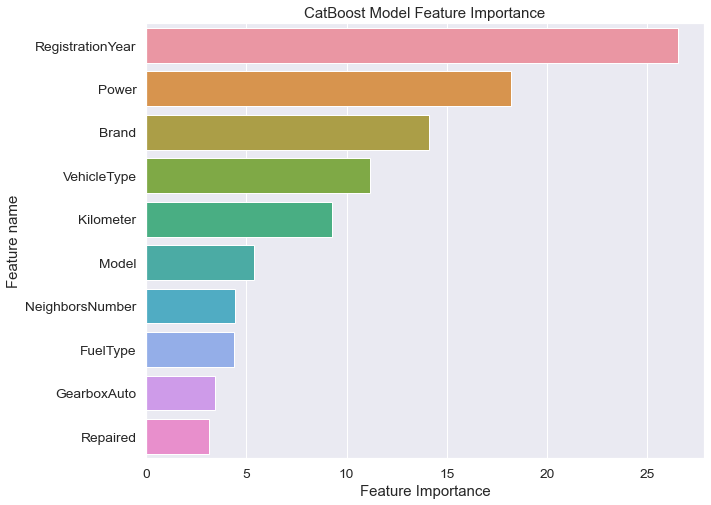

In [87]:
plot_feature_importance(X_train, model_cb, 'CatBoost')

### Conclusion

Catboost model showed the best results: 2.5 times faster than LightGMB and 5 times faster than Polynomial Ridge Regression. The prediction accuracy of the Catboost model is at the same level as LightGBM and 30% better than Polynomial Ridge Regression.


## Test of the Best Model

Let's test the best model based on the results of cross-validation and prediction time - the CatBoost gradient boosting model.

In [88]:
X_test_pool = Pool(data=X_test,
                   label=y_test, 
                   cat_features=['Brand', 'Model', 'VehicleType', 'FuelType'], 
                   feature_names=list(X_test.columns))
pred_cb_test = model_cb.predict(X_test_pool)

In [89]:
rmse_cb = mean_squared_error(y_test, pred_cb_test, squared=False)

In [90]:
f'RMSE: {rmse_cb}'

'RMSE: 1581.8454959564474'

We will check the adequacy of the model in comparison with the constant model.

In [91]:
dummy = DummyRegressor()
dummy.fit(X_train, y_train)
pred_dummy = dummy.predict(X_test)

In [92]:
rmse_dummy = mean_squared_error(y_test, pred_dummy, squared=False)

In [93]:
rmse_dummy

4542.732071772272

###  Conclusion

We tested and checked the adequacy of the model in comparison with the constant model. Validation passed. The result on the test sample was lower than on the results of cross-validation.

## Summary

During the study, the following work was carried out:
  - **Data analysis and data preprocessing. Based on the results of the analysis, the following features were found in the initial data:**
1. Passes. In total, we have five columns with missing values:
    - VehicleType 37490 We can fill in by the most frequently used brand and model.
    - Gearbox 19833 We can fill in by the most frequent by brand and model.
    - Model 19705 We can fill in by brand and year of registration.
    - FuelType 32895 Fill in by the most frequently used brand and model.
    - Repaired 71154 Fill in with zeros (we assume that it is indicated as car not being repaired)
    - according to the given columns, set the data type as 'category'
2. Data type mismatch
    - Repaired object (convert to bool)
    - Gearbox object (convert to bool)
3. Uninformative features.
    - NumberOfPictures
    - RegistrationMonth
    - LasetSeen
    - DateCreated
    - Datacrawled
5. Too big power values (> 1000 hp). Remove abnormally large values. Too small - refill based on model information.
6. The maximum possible mileage encountered is 150 thousand km.

- **Source data conversion:**
    - Missing values were filled in five columns:
      - Model
      - FuelType
      - VehicleType
      - Gearbox
      - Repaired
    - Fixed too low power values and removed abnormally high ones.
    - Anomalies in the RegistrationYear column have been removed.
    - 5 uninformative features were removed.
    - Removed duplicated lines
    - A new feature has been introduced - NeighborsNumber, which indirectly reflects the demand in the area where the ad was placed, the original PostalCode feature has been removed
    - Transformations of data type of features were made.
    - Checked multicollinearity features.
    
- **Test five different machine learning models**
    Two models based on gradient boosting and three linear ones were taken for the study. As a result, three of them showed satisfactory values of RMSE (< 2500) :
    - LightGBM
    - catboost
    - Polynomial Ridge Regression    


- **Model Quality Analysis**
  According to the results of the analysis, the Catboost model showed the best results. It 2.5 times faster than LightGMB and 5 times faster than Poltnomial Ridge Regression. The prediction accuracy of the Catboost model is at the same level as LightGBM and 30% better than Poltnomial Ridge Regression.
The final choice fell on the CatBoost gradient boosting model. We tested and checked the adequacy of the model in comparison with the constant model. The result on the test sample is the same as at cross-validation on train set.